# Исследование вакансий HeadHunter.ru по запросу "data python"



**Цель исследования**

---

Рассмотреть актуальные вакансии сайта HeadHunter.ru:
1. Количество вакансий определенных типов (должностей).
2. Основные требуемые навыки (key skills) для работы - для всех и для определенных типов.
3. Проф области компаний и сами компании.
4. Отклики.
5. Заработные платы.

---

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
sns.set_theme()
import matplotlib.pyplot as plt
import re
import requests
import datetime 
import random
from IPython.display import Markdown
 
import os

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

Добавим класс с параметрами и создадим функцию по генерации цвета - для некоторых графиков.

In [2]:
class parameters:
    SEED = 42
    np.random.seed(SEED)
    
def random_color():
    color = "#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])
    return color

In [3]:
df = pd.read_csv('data_python.csv', index_col=0)

df.drop_duplicates(inplace=True)

df.head()

,id,name,company,industries,city,experience,salary,responses,description,key_skills,url
0,71808543,Data Scientist,Автомакон,NaN,Москва,От 1 года до 3 лет,от 150000 до 300000 RUR на руки,261.0,<p><strong>ГК «Автомакон»</strong> – системный...,"Python, Tensorflow, PyTorch, Pandas, Numpy",https://hh.ru/vacancy/71808543
1,72050507,Junior Data Engineer / Data Analyst,WhoIsBlogger (WIB),"Интернет-компания (поисковики, платежные систе...",Москва,От 1 года до 3 лет,от 60000 до 120000 RUR на руки,59.0,<p><strong>WhoIsBlogger (WIB) - </strong>это I...,"SQL, Git, Python, Atlassian Jira, Atlassian Co...",https://hh.ru/vacancy/72050507
2,71906648,Data Scientist / Junior Data Scientist (удаленно),Горбунов Илья Николаевич,NaN,Новосибирск,От 1 года до 3 лет,NaN,119.0,"<p>Мы, Dataacquisition.ru , команда энтузиасто...","Python, SQL, Linux, Numpy, Pandas, Machine Lea...",https://hh.ru/vacancy/71906648
3,72082374,Data Analyst / Data Scientist (GameDev),Amaya Soft,"Интернет-компания (поисковики, платежные систе...",Санкт-Петербург,От 1 года до 3 лет,NaN,29.0,<p>Привет! Мы в <strong>AmayaSoft </strong>зан...,"Python, SQL, Анализ данных, Аналитика, A/B тесты",https://hh.ru/vacancy/72082374
4,71559745,Data scientist / ML разработчик,Loymax,Разработка программного обеспечения,Москва,От 3 до 6 лет,от 120000 до 220000 RUR на руки,260.0,<p><strong>Компания Loymax - лидер на рынке IT...,"Python, SQL, A/B тесты, Airflow, Spark, Flask,...",https://hh.ru/vacancy/71559745


In [4]:
df.info()

print('\n')

Markdown(
    f'Количество строк в выгруженном датасете: **{len(df)}**.\
    <br> Приступим к обработке данных'
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1480
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1454 non-null   int64  
 1   name         1454 non-null   object 
 2   company      1454 non-null   object 
 3   industries   1291 non-null   object 
 4   city         1454 non-null   object 
 5   experience   1454 non-null   object 
 6   salary       178 non-null    object 
 7   responses    1454 non-null   float64
 8   description  1454 non-null   object 
 9   key_skills   1246 non-null   object 
 10  url          1454 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 136.3+ KB




Количество строк в выгруженном датасете: **1454**.    <br> Приступим к обработке данных

Алгоритм предобработки:

1. Очистим описание вакансии от html тегов.
2. Выделим из каждой вакансии:
    - *валюту заработной платы*
    - *грейд вакансии*
    - из названия вакансии выделим *тип*, основаный на основных популярных вакансиях и разделим на 2 типа: *основной* и *подтип*.
4. Разделим **уровень дохода** на *от* и *до*, а так же заполним пропуски.

Приступим к обработке данных:

### Очистка тэгов HTML

**Убираем теги из вакансии:**

In [5]:
TAG_PATTERN = re.compile(r'<[^>]+>')

def clear_html_tags(v):
    return TAG_PATTERN.sub('', v)

df['description'] = df['description'].apply(clear_html_tags)

### Выделяем инфу из названия

**Выделяем тип валюты:**

In [6]:
df['currency'] = df['salary'].apply(lambda x: re.sub('[^a-zA-Z]+', '', str(x)))

**Создадим функцию для выделения грейда вакансии** и выделим грейды.

In [7]:
def make_grade_new(name: str) -> str:

    simple_grade = str()
    
    for grade in grades:
        if any(word in name.lower() for word in grade):
            simple_grade += grade[0] + ', '

    if simple_grade != str():
        return simple_grade.strip(', ')
    else:
        pass

За основные грейды вакансий будут выделены:

- **intern** - стажер
- **junior** - младший (он же джун)
- **middle** - ведущий (мид)
- **senior** - старший (сеньор)
- **lead** - руководитель (он тимлид)
- **chief** - начальник (шеф)

Если в вакансии будут 2 и более грейда - выделим 1-ый как основной.

In [8]:
grades = [
    ['intern', 'стажер', 'стажёр'],
    ['junior', 'младший'],
    ['middle', 'ведущий'],
    ['senior', 'старший'],
    ['lead', 'руководитель'],
    ['chief', 'начальник']
]

df['grade'] = df['name'].apply(make_grade_new)
df['grade_1'] = df['grade'].apply(lambda x: x.split(', ')[0] if x != None else None)

Воспользуемся созданной функцией и выделем **типы вакансий** (должности). 

Так как рассматриваются вакансии по запросу `data python` выделим основные направления:

- data analyst
- data scientist
- data engineer
- web analyst
- product analyst
- BI analyst
- system analyst
- SQL analyst
- ML engineer
- architect
- frontend developer
- backend developer
- QA engineer
- security engineer
- programmer 
- analyst

В вакансиях часто требуется сотрудник, отвечающий двум-трём типам, соответственно тип будет указан через запятую. И выделим так же два основных типа вакансии в отдельные столбцы. Приоритетной должностью будем считать ту, которая указана первой.

Вакансии указаны в таком порядке, чтобы слово `analyst` не перекрывало остальные типы, так как встречается в большинстве вакансий.

> **Примечание:** необходима доработка кода по распределению типа вакансии, так как возможна неправильная порядочность типа, что может исказить исследование. На данный момент такие погрешности низки, но лучше их исключить для более точного исследования.

In [9]:
grades = [
    ['data analyst',
     'da ', 
     'data-аналитик', 
     'data аналитик',
     'анализ данных',
     'аналитик данных', 
     'анализу данных'],

    ['data scientist',
     'data science',
     'ds ',
     'исследователь данных', 
     'аналитик разработчик', 
     'аналитик-разработчик', 
     'аналитик исследователь', 
     'специалист-математик', 
     'специалист математик', 
     'аналитик - математик',
     'аналитик-математик',
     'computer vision', 
     'cv', 'nlp'],

    ['data engineer', 
     'data-engineer'
     'data инженер',
     'data-инженер', 
     'дата-инженер',
     'дата инженер',
     'инженер данных', 
     'разработчик базы'],

    ['web analyst', 
     'web аналитик',
     'веб аналитик',
     'веб-аналитик',
     'web-analyst', 
     'аналитик-web', 
     'analyst-web'],

    ['product analyst', 
     'продуктовый аналитик', 
     'porduct-analyst', 
     'аналитик продукта', 
     'продуктовый-аналитик'],

    ['bi analyst',
     'PowerBI analyst', 
     'analyst PowerBI', 
     'analyst bi',
     'аналитик bi',
     'bi аналитик',
     'bi-аналитик',
     'аналитик power bi', 
     'аналитик powerbi',
     'business analyst', 
     'бизнес-аналитик', 
     'бизнес аналитик'], 
     
    ['system analyst', 
     'system-analyst', 
     'системный-аналитик',
     'системный аналитик'],

    ['sql analyst', 
     'аналитик sql', 
     'sql', 
     'аналитик sql'],

    ['ml engineer',
     'ml',
     'machine learning', 
     'машин',
     'ml-engineer'],

    ['devops'],

    ['architect', 
     'архитектор'],

    ['frontend', 
     'front end'],

    ['backend', 
     'back end'],

    ['qa engineer', 
     'qa',
     'тест', 
     'test',
     'quality'],

    ['security engineer', 
     'безопасн', 
     'secur'],

    ['programmer', 
     'developer', 
     'software',
     'программист', 
     'разработчик'],

    ['analyst', 
     'analytics',
     'аналитик']
]

df['type'] = df['name'].apply(make_grade_new)
df['type_1'] = df['type'].apply(lambda x: x.split(', ')[0] if x != None else None)
df['type_2'] = df['type'].apply(lambda x: x.split(', ')[1] if (x != None and len(x.split(', ')) > 1) else None)

### ЗП и пропуски

Предобработаем столбец с указанием **заработной платы**:

1. Выделим *to* и *from*
2. В случае, если указано, что **GROSS** - пересчитаем на **NET** (возьмём как 13% по РФ)
3. Пересчитаем все на рубли, если указана иностранная валюта (данные возьмем с [сайта](https://api.exchangerate-api.com/v4/latest/EUR))
4. Заполним пропуски в столбцах *to* и *from*

In [10]:
def change_salary(salary):

    if salary is np.nan:
        return

    text = salary.split(' ')

    if 'от' in salary:
        s_from = int(text[text.index('от')+1])
    else:
        s_from = np.nan

    if 'до' in text:
        s_to = text[text.index('до')+1]
        if s_to == 'вычета':
            s_to = np.nan
        else:
            s_to = int(s_to)
    else:
        s_to = np.nan

    if 'до вычета' in salary:
        s_from *= 0.87
        s_to *= 0.87

    return pd.Series([s_from, s_to])

Заполним пропуски в столбцах:

- высчитаем средний процент, насколько отличается *from* от *to*
- при наличии пропуска заполним исходя из этого процента

> данный процент даст знать, на сколько в среднем работодатель согласен заплатить больше/меньше при указанном промежутке 

Создадим отдельный датайфрейм, выполним предобработку и объединим с исходным:

In [11]:
df_s = df[['id', 'salary', 'currency']]

df_s.dropna(inplace=True)
df_s = df_s.reset_index(drop=True)

In [12]:
def fill_salary(row, data=df_s):

    global percent
    percent = 1 - round((data['from'] / data['to']).median(), 2)

    s_to = row['to']
    s_from = row['from']

    if pd.isna(s_to):
        s_to = s_from + s_from * percent

    if pd.isna(s_from):
        s_from = s_to - s_to * percent

    return pd.Series([s_from, s_to])

In [13]:
df_s[['from', 'to']] = df_s['salary'].apply(change_salary)

url = 'https://api.exchangerate-api.com/v4/latest/EUR'
EUR = requests.get(url).json()['rates']['RUB']
url = 'https://api.exchangerate-api.com/v4/latest/USD'
USD = requests.get(url).json()['rates']['RUB']

url = 'https://api.exchangerate-api.com/v4/latest/EUR'
json = requests.get(url).json

df_s.loc[(df_s['currency'] == 'USD') & ~(df_s['to'].isna()), 'to'] *= USD
df_s.loc[(df_s['currency'] == 'USD') & ~(df_s['from'].isna()), 'from'] *= USD

df_s.loc[(df_s['currency'] == 'EUR') & ~(df_s['to'].isna()), 'to'] *= EUR
df_s.loc[(df_s['currency'] == 'EUR') & ~(df_s['from'].isna()), 'from'] *= EUR

df_s[['from', 'to']] = df_s.apply(fill_salary, axis=1)

df = df.merge(df_s[['id', 'from', 'to']], how='outer', on='id')

Обработаем столбец `industries` - добавим перенос строки, чтобы на графиках было отображено плотнее.

In [14]:
def industries_split(text):
    
    lst = text.split(' ')
    
    if len(lst) >= 12:
        length = round(len(lst)//4)
        indexes = [length, 2*length, 3*length]
        lst.insert(indexes[0], '\n')
        lst.insert(indexes[1], '\n')
        lst.insert(indexes[2], '\n')
        
    if (len(lst) > 7) and (len(lst) < 12):
        length = len(lst)//2
        lst.insert(length, '\n')
        
    return ' '.join(lst)

In [15]:
df['industries'] = df['industries'].apply(lambda x: industries_split(x) if not pd.isna(x) else x)

Итоговая таблица:

In [16]:
df.head()

,id,name,company,industries,city,experience,salary,responses,description,key_skills,url,currency,grade,grade_1,type,type_1,type_2,from,to
0,71808543,Data Scientist,Автомакон,NaN,Москва,От 1 года до 3 лет,от 150000 до 300000 RUR на руки,261.0,ГК «Автомакон» – системный интегратор IT-решен...,"Python, Tensorflow, PyTorch, Pandas, Numpy",https://hh.ru/vacancy/71808543,RUR,None,None,data scientist,data scientist,None,150000.0,300000.0
1,72050507,Junior Data Engineer / Data Analyst,WhoIsBlogger (WIB),"Интернет-компания (поисковики, платежные \n си...",Москва,От 1 года до 3 лет,от 60000 до 120000 RUR на руки,59.0,WhoIsBlogger (WIB) - это Influencer Marketing ...,"SQL, Git, Python, Atlassian Jira, Atlassian Co...",https://hh.ru/vacancy/72050507,RUR,junior,junior,"data analyst, data engineer, analyst",data analyst,data engineer,60000.0,120000.0
2,71906648,Data Scientist / Junior Data Scientist (удаленно),Горбунов Илья Николаевич,NaN,Новосибирск,От 1 года до 3 лет,NaN,119.0,"Мы, Dataacquisition.ru , команда энтузиастов в...","Python, SQL, Linux, Numpy, Pandas, Machine Lea...",https://hh.ru/vacancy/71906648,nan,junior,junior,data scientist,data scientist,None,NaN,NaN
3,72082374,Data Analyst / Data Scientist (GameDev),Amaya Soft,"Интернет-компания (поисковики, платежные \n си...",Санкт-Петербург,От 1 года до 3 лет,NaN,29.0,Привет! Мы в AmayaSoft занимаемся разработкой ...,"Python, SQL, Анализ данных, Аналитика, A/B тесты",https://hh.ru/vacancy/72082374,nan,None,None,"data analyst, data scientist, analyst",data analyst,data scientist,NaN,NaN
4,71559745,Data scientist / ML разработчик,Loymax,Разработка программного обеспечения,Москва,От 3 до 6 лет,от 120000 до 220000 RUR на руки,260.0,Компания Loymax - лидер на рынке IT решений по...,"Python, SQL, A/B тесты, Airflow, Spark, Flask,...",https://hh.ru/vacancy/71559745,RUR,None,None,"data scientist, ml engineer, programmer",data scientist,ml engineer,120000.0,220000.0


Данные предобработаны, приступим к анализу рынка HH.

## EDA

В качестве анализа рассмотрим:

1. Типы вакансий и их количество, основные навыки, грейды.
2. Отлики, опыт работы.
3. Распределение вакансий по городам (топ-5 вакансий в городе)
4. Проф. область компаний.
5. Заработные платы.

### Типы вакансий

Рассмотрим самые популярные вакансии по запросу в HH и выделим топ-6:

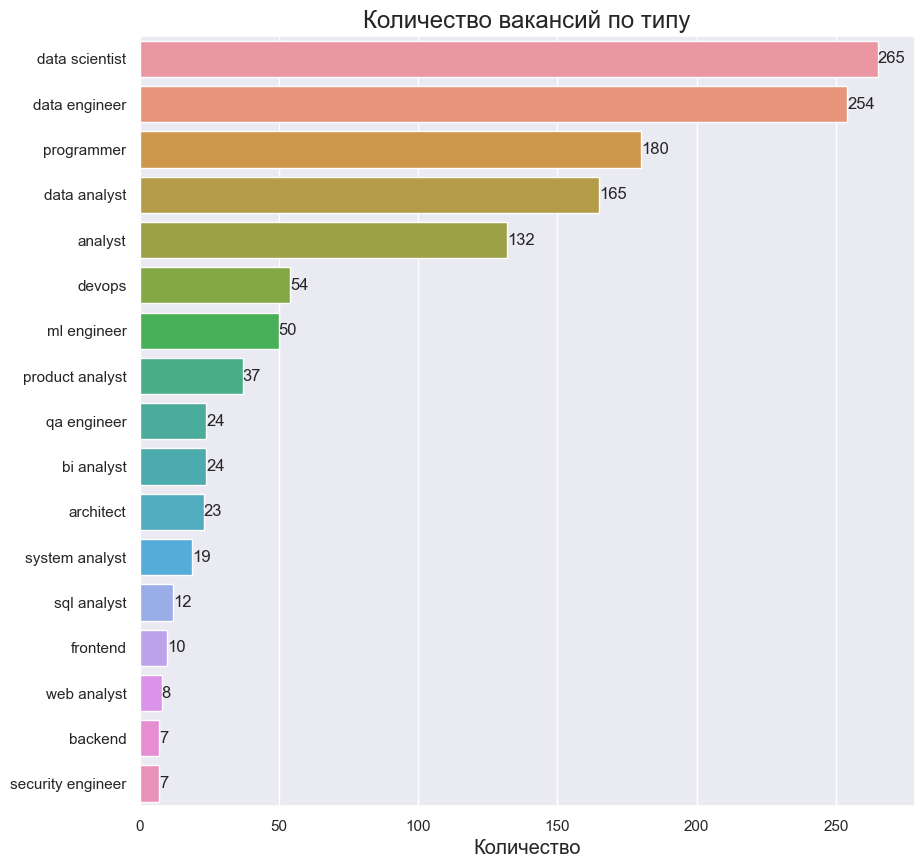

In [17]:
counts = df['type_1'].value_counts()
counts_top = counts[0:6]

colors = [random_color() for x in range(len(counts_top))]

plt.figure(figsize=(10,10))
plt.tight_layout()
plt.title('Количество вакансий по типу', fontsize='x-large')
ax = sns.barplot(y=counts.index, x=counts, orient='h')
ax.bar_label(ax.containers[0])
plt.xlabel('Количество', fontsize='large')
plt.savefig('./img/vacancies_count.jpg', bbox_inches='tight')
plt.show()

Самые популярные вакансии на рынке:

- **data scientist**
- **data engineer**
- **data analyst**
- **programmer**
- **analyst**
- **devops**

Видно, что в сумме аналитики более востребованы, в отличии от инженеров данных и саентистов. 

Топ-6 включает в себя и `devops`, хотя и идет с большим отрывом от популярных вакансий.

### Вакансии по городам

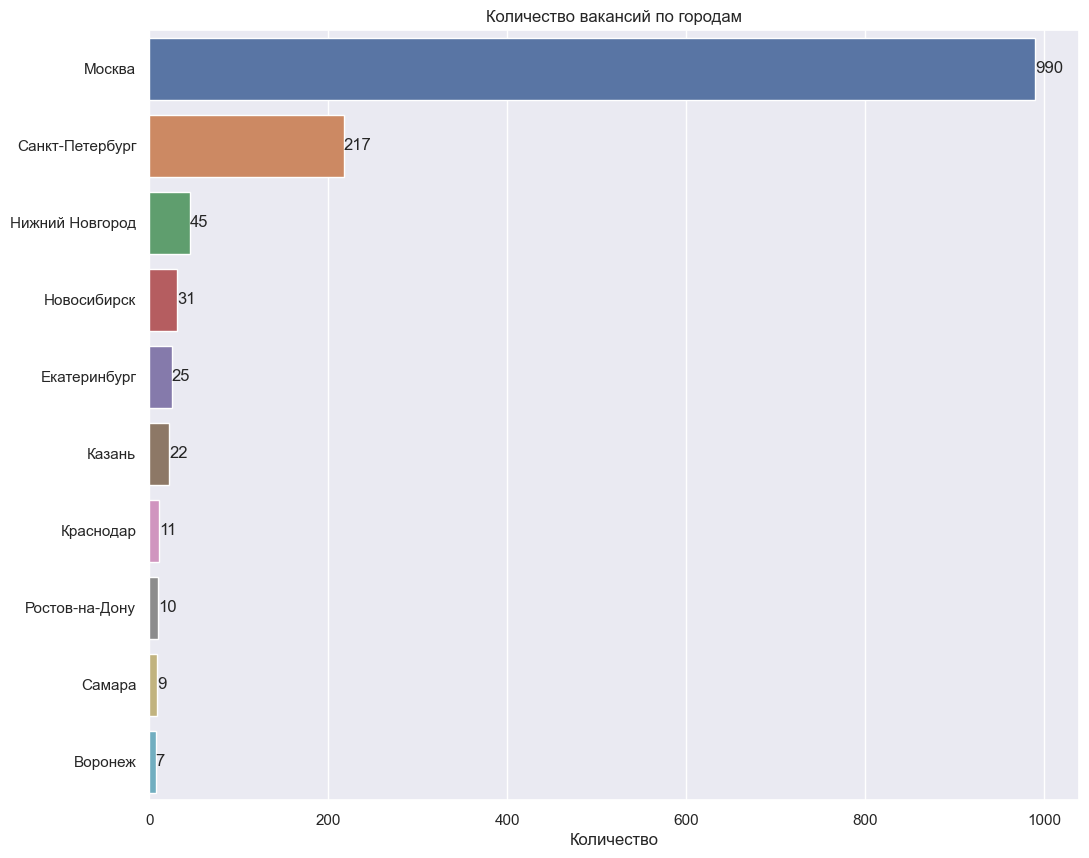

In [18]:
top_city = df.groupby('city')['id'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 10))
plt.tight_layout()
ax = sns.barplot(y=top_city.index, x=top_city, orient='h')
ax.bar_label(ax.containers[0])
plt.title('Количество вакансий по городам')
plt.xlabel('Количество')
plt.ylabel('', visible=False)
plt.savefig('./img/vacancies_cities.jpg', bbox_inches='tight')
plt.show()

Большинство вакансий в столице - **Москва**. В 4 раза меньше в **Санкт-Петербурге**.

И дальше идёт на убывание.

Выделим 6 городов с наибольшим количеством вакансий и рассмотрим, кто более востребован в городе:

In [19]:
top_cities = df['city'].value_counts(ascending=False).head(6)

top_cities = df.pivot_table(
                index='city', 
                columns='type_1', 
                aggfunc='count', 
                fill_value=0
            )['id'].loc[top_cities.index]

Функцией будем отделять количество вакансий по типу в городе:

In [20]:
def city_for_pie(city, top=5, data=top_cities):

    data_city = data.loc[city].sort_values(ascending=False)
    others = data_city[top:].cumsum()[-1]
    data_city = data_city[:top]
    data_city.loc['Others'] = others

    return data_city

Построим круговые диаграммы:

Возьмём **топ-5** вакансий в городе, остальные будут учтены в `others` - так как соотношение к общему числу отдельно каждого в целом меньше самых популярных вакансий (для простоты визуализации). 

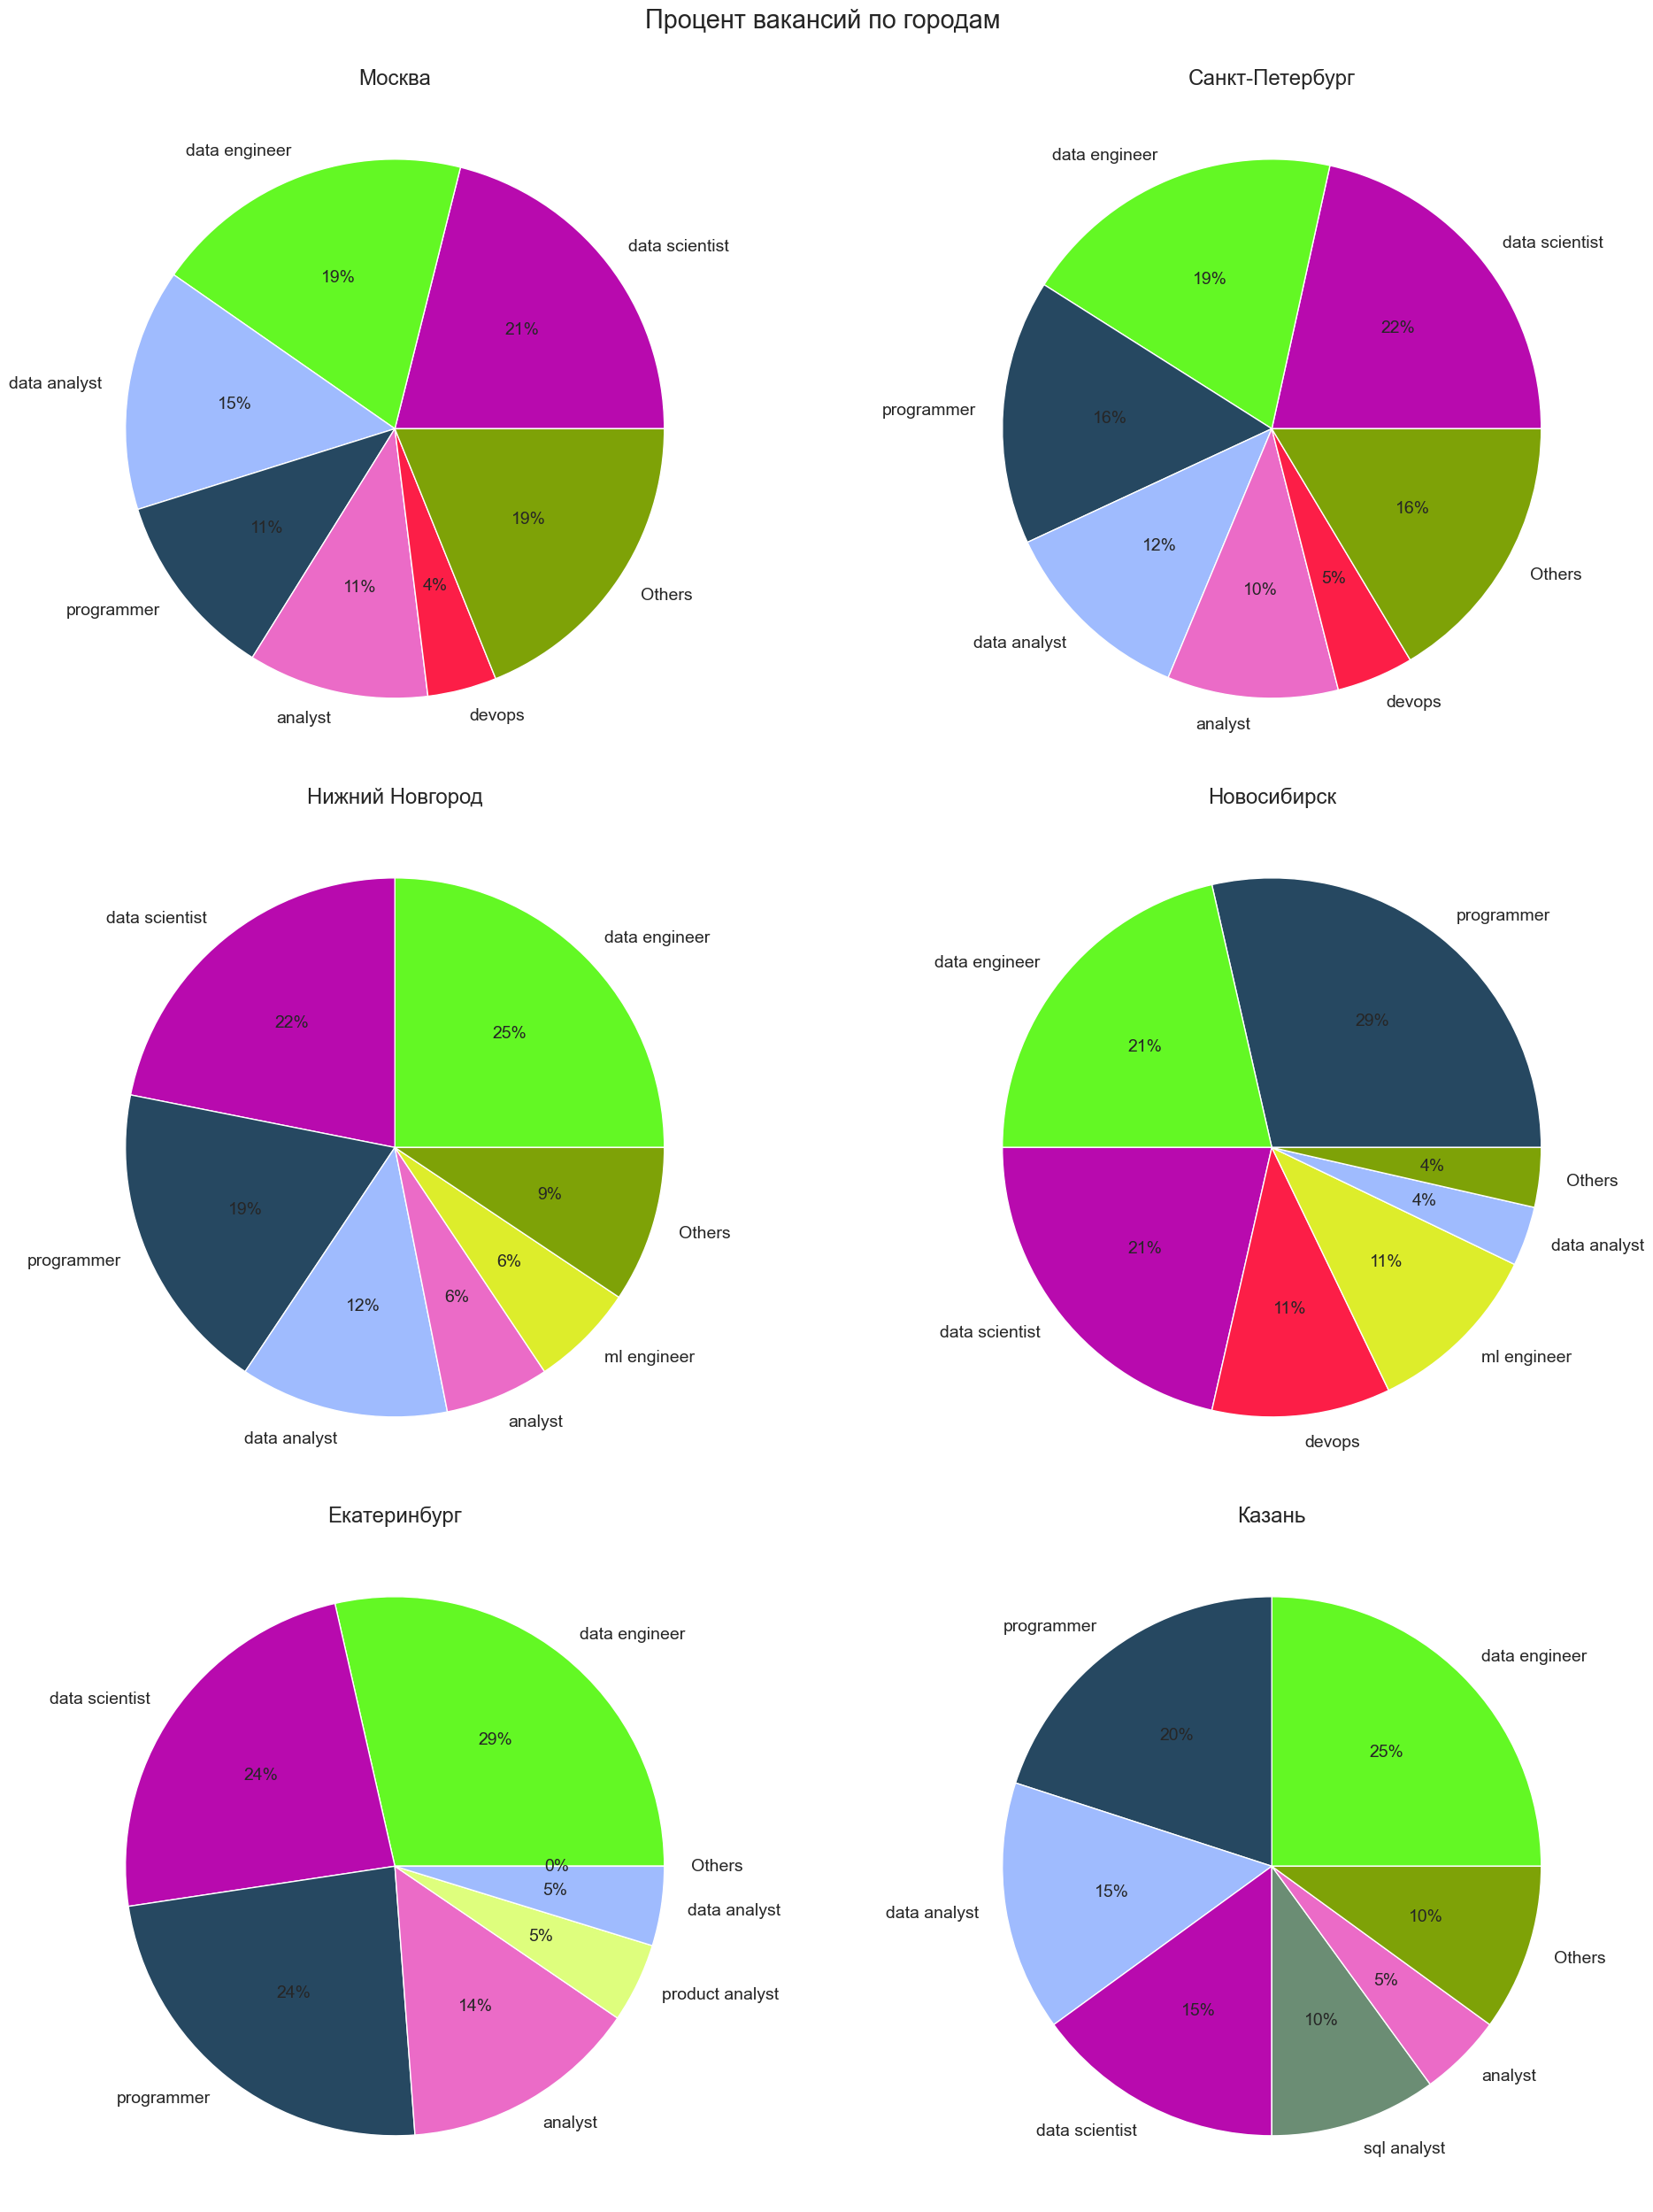

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(20, 25))
fig.suptitle('Процент вакансий по городам', fontsize='xx-large', y=1.01)
fig.tight_layout()

colors_type = dict([(x, random_color()) for x in df['type_1'].unique()])
colors_type['Others'] = random_color()

i=0
for x in range(3):
    for y in range(2):
        city = city_for_pie(top_cities.index[i], top=6)
        colors_now = []
        for name in city.index:
            colors_now.append(colors_type[name])
        ax[x, y].pie(city, labels=city.index, autopct='%.0f%%', colors=colors_now, textprops={'fontsize': 14})
        ax[x, y].set_title(f'{top_cities.index[i]}', fontsize='x-large')
        i += 1
        
plt.savefig('./img/pies_types_cities.jpg', bbox_inches='tight')
plt.show()

Как видно, в двух наиболее крупных городах лидерами по поиску разделяют **четыре** типа:

- **data scientist**
- **data engineer**
- **data analyst**
- **programmer**

Наиборлее востребованы всё же data scientist'ы и инженеры данных.

В остальных городах, где вакансий значительно меньше вакансий - разброс по требованию выше. Статистика слишком мала (до 40 вакансий), чтобы делать конечные выводы. Тренд сейчас идет на увеличение количества вакансий в стране, после чего можно будет сделать конечные выводы. 


### Грейды и опыт

Построим диаграммы по количеству вакансий определённых грейдов и опыта работы, которые востребованы на рынке:

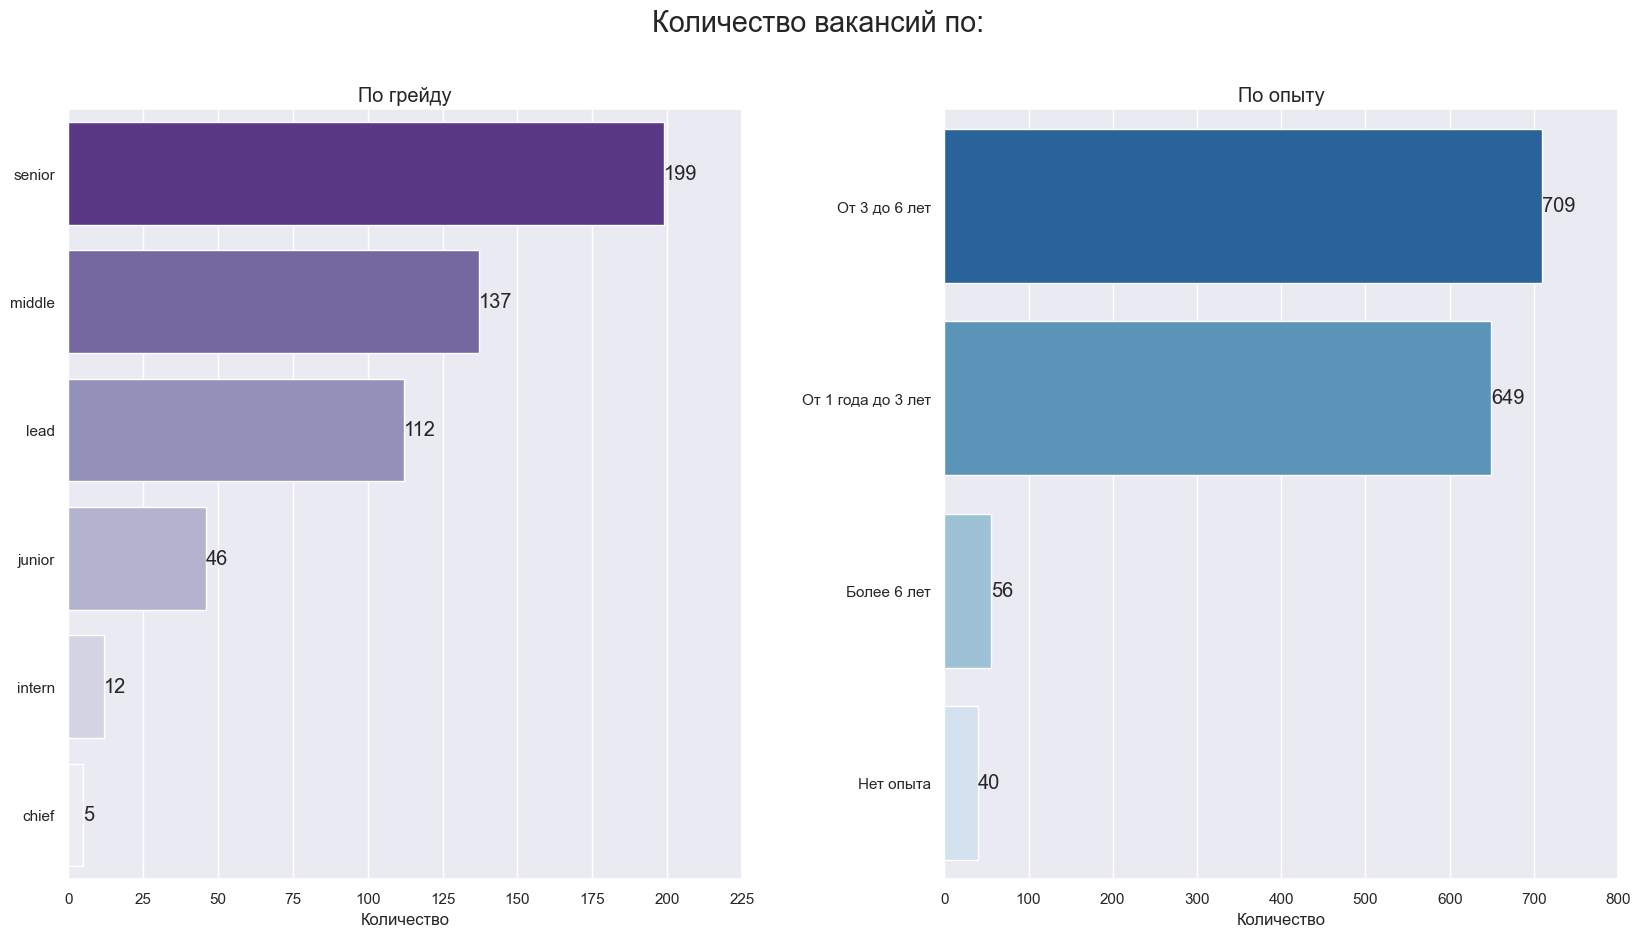

In [22]:
grade_count = df.groupby('grade_1')['id'].count().sort_values(ascending=False)
exp_count = df.groupby('experience')['id'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(20, 10))
fig.tight_layout()
fig.suptitle('Количество вакансий по:', fontsize='xx-large')

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

sns.barplot(y=grade_count.index, x=grade_count, orient='h', palette='Purples_r', ax=ax1)
ax1.set_title('По грейду', fontsize='large')
ax1.set_ylabel('', visible=False)
ax1.set_xlabel('Количество')
ax1.bar_label(ax1.containers[0], fontsize='large')
ax1.set_xlim(0, 225)

sns.barplot(y=exp_count.index, x=exp_count, orient='h', palette='Blues_r', ax=ax2)
ax2.set_title('По опыту', fontsize='large')
ax2.set_ylabel('', visible=False)
ax2.set_xlabel('Количество')
ax2.bar_label(ax2.containers[0], fontsize='large')
ax2.set_xlim(0, 800)

plt.subplots_adjust(wspace=0.3)
plt.savefig('./img/grades_exp_count.jpg', bbox_inches='tight')
plt.show()

Как видно, для большинства компаний, наиболее востребованы кандидаты с грейдом `senior` и выше и опытом выше 1 года.

Так же востребованы специалисты уровня `middle` и `lead`, скорее всего из-за сложившейся ситуации.

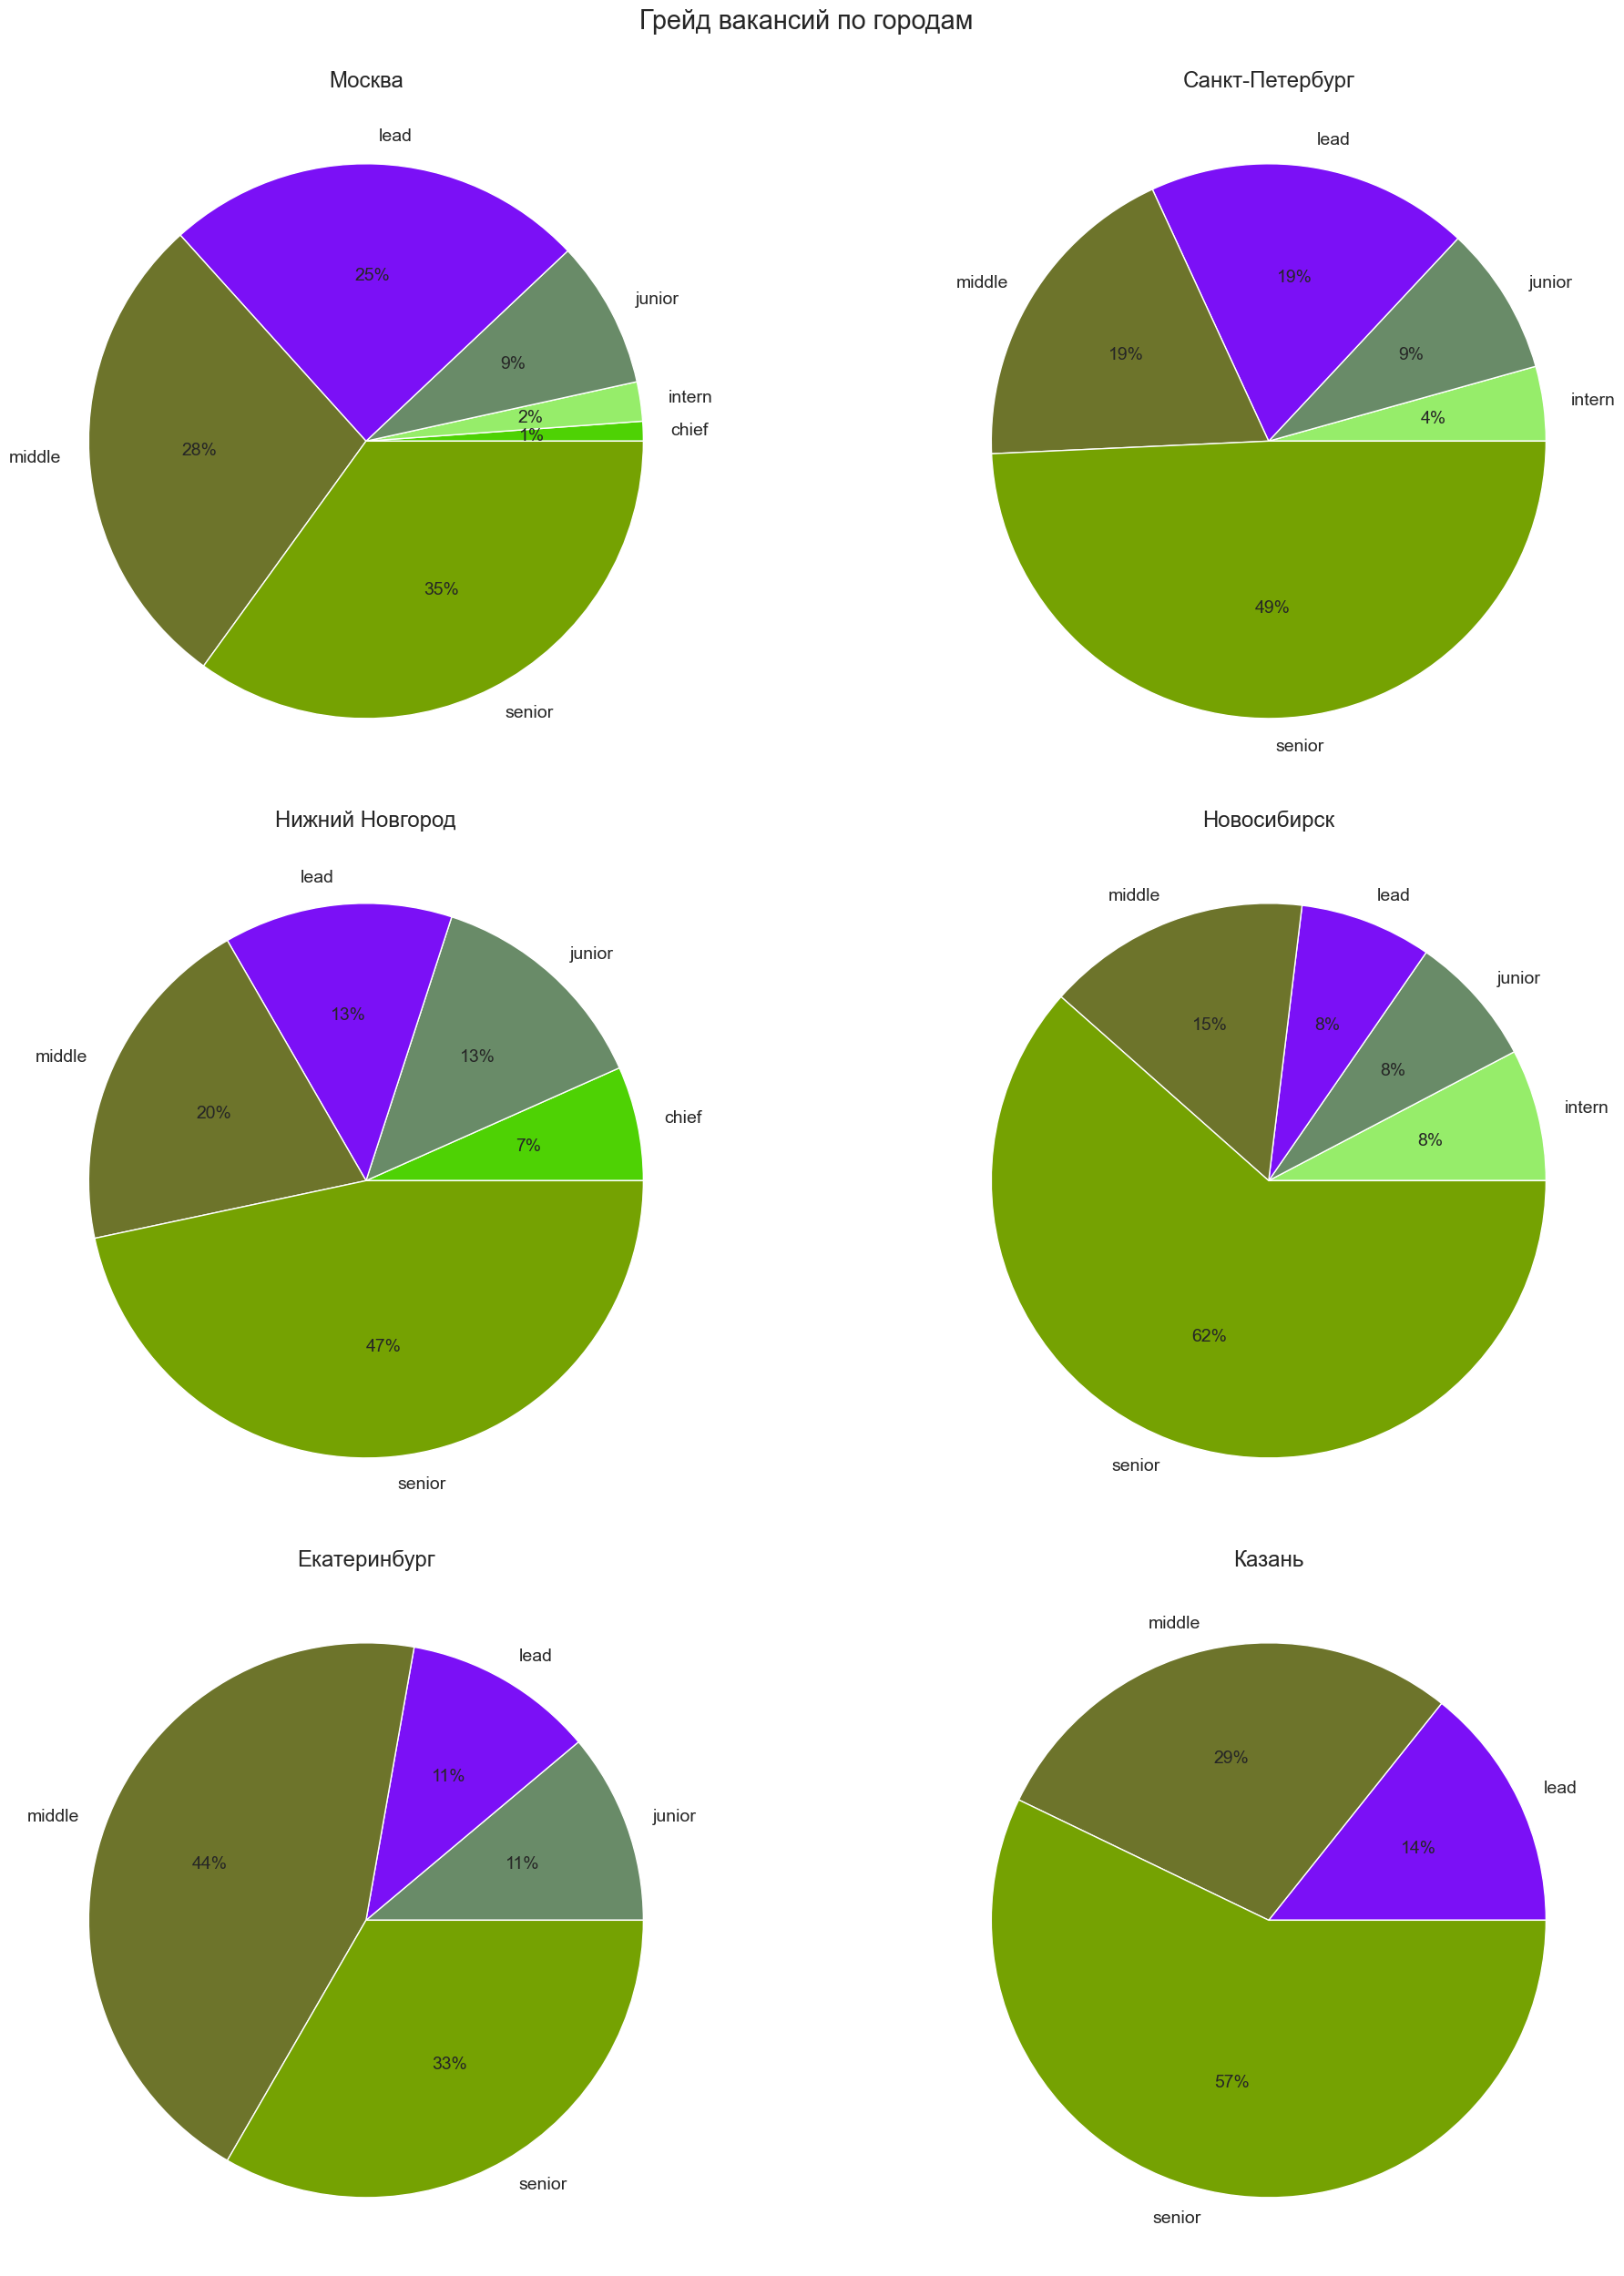

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(20, 25))
fig.suptitle('Грейд вакансий по городам', fontsize='xx-large', y=1.01)
fig.tight_layout()

colors_type_g = dict([(x, random_color()) for x in df['grade_1'].unique()])

i = 0
for x in range(3):
    for y in range(2):
        city = df[df['city'] == top_cities.index[i]].groupby('grade_1').count()['id']
        colors_now = []
        for name in city.index:
            colors_now.append(colors_type_g[name])
        ax[x, y].pie(city, labels=city.index, autopct='%.0f%%', colors=colors_now, textprops={'fontsize': 14})
        ax[x, y].set_title(f'{top_cities.index[i]}', fontsize='x-large')
        i += 1
        
plt.savefig('./img/grades_cities_count.jpg', bbox_inches='tight')
plt.show()

Как видно из графиков, в `6` городах с наибольшим количеством вакансий чаще ищут именно специалистов уровня `senior` и `middle`.

### Отклики


Рассмотрим самые популярные вакансии у соискателей - **количество откликов**:

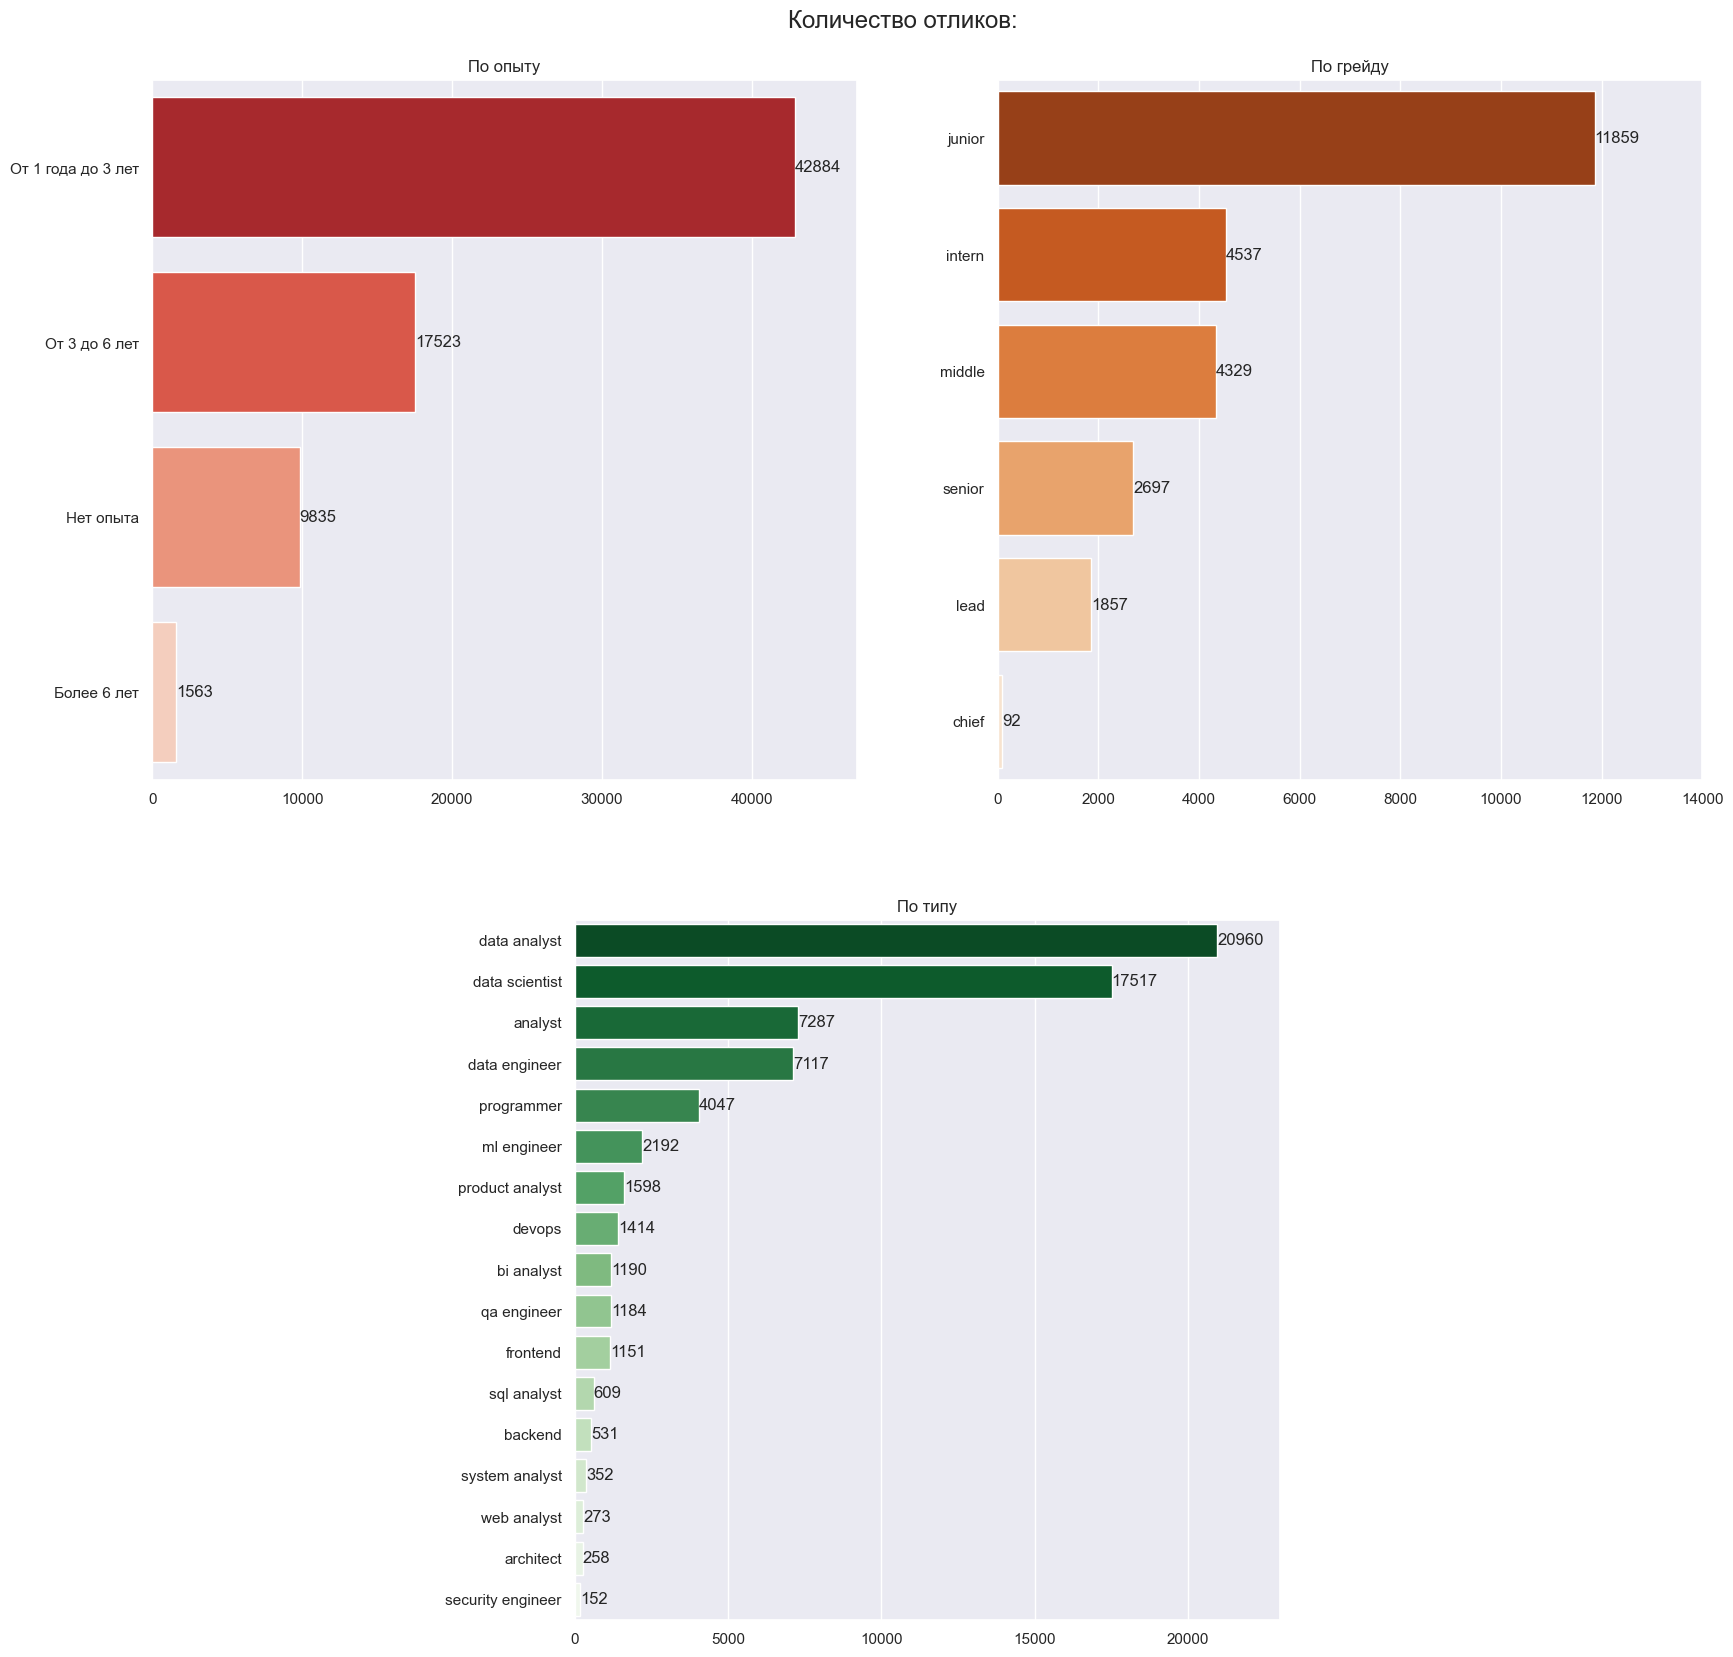

In [24]:
fig = plt.figure(figsize=(20, 20), layout="constrained")
spec = fig.add_gridspec(2, 4)
spec.update(wspace=0.5)

ax1 = plt.subplot(spec[0, :2])
ax2 = plt.subplot(spec[0, 2:])
ax3 = plt.subplot(spec[1, 1:3])

experience_type = df.groupby('experience')['responses'].sum().sort_values(ascending=False)
sns.barplot(y=experience_type.index, x=experience_type, orient='h', palette='Reds_r', ax=ax1)
ax1.set_title('По опыту')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.bar_label(ax1.containers[0])
ax1.set_xlim(0, 47000)

grade_type = df.groupby('grade_1')['responses'].sum().sort_values(ascending=False)
sns.barplot(y=grade_type.index, x=grade_type, orient='h', palette='Oranges_r', ax=ax2)
ax2.set_title('По грейду')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.bar_label(ax2.containers[0])
ax2.set_xlim(0, 14000)

respon_type = df.groupby('type_1')['responses'].sum().sort_values(ascending=False)
sns.barplot(y=respon_type.index, x=respon_type, orient='h', palette='Greens_r', ax=ax3)
ax3.set_title('По типу')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.bar_label(ax3.containers[0])
ax3.set_xlim(0, 23000)

fig.suptitle('Количество отликов:', y=0.915, fontsize='x-large')

plt.savefig('./img/responses_count.jpg', bbox_inches='tight')
plt.show()

Самые востребованные вакансии у соискателей:

- **data analyst**
- **data scientist**

И соответсвенно, чаще откликаются на грейды `junior` и ниже с требуемым опытом работы *от 1 года*. 

### Key skills

Рассмотрим популярные навыки - высчитаем количество вакансий с требованиями по key skills.

 Будем выделять названия навыка на **английском** и **русском** языке, так как на английском указан в основном технологический стек (например `python` или `sql`).

In [25]:
'''
Функция по выводу ключевых навыков - всех типов/от типа:

    vac_type указывается точное название типа, которое есть в столбце type_1

    language:
        ru - если нужны навыки на русском языке
        en - на английском
        любое значение - вывод без фильтра
'''

def check_skills(
        vac_type=None, 
        language='en', 
        data=df
    ) -> pd.Series:

    if vac_type is not None:
        data_filtered = data[data['type_1'] == vac_type]
        df_ks = data_filtered[['id', 'key_skills']]
        df_ks = df_ks.dropna(subset=['key_skills']).reset_index(drop=True)

    else:
        df_ks = data[['id', 'key_skills']]
        df_ks = df_ks.dropna(subset=['key_skills']).reset_index(drop=True)

    for i in range(len(df_ks)):
        x = df_ks.key_skills[i].split(', ')
        for key in x:
            if key in df_ks.columns:
                df_ks.loc[i, key] = 1
            else:
                df_ks[key] = 0
                df_ks.loc[i, key] = 1

    sum_ks = pd.Series(df_ks.cumsum().loc[len(df_ks)-1]).drop(['id', 'key_skills'], axis=0)

    if language == 'en':
        top_ks = sum_ks.filter(regex='[a-zA-Z+]+$').sort_values(ascending=False).head(15)
    elif language == 'ru':
        top_ks = sum_ks.filter(regex='[^a-zA-Z+#]+$').sort_values(ascending=False).head(15)
    else:
        top_ks = sum_ks.sort_values(ascending=False).head(15)

    return top_ks

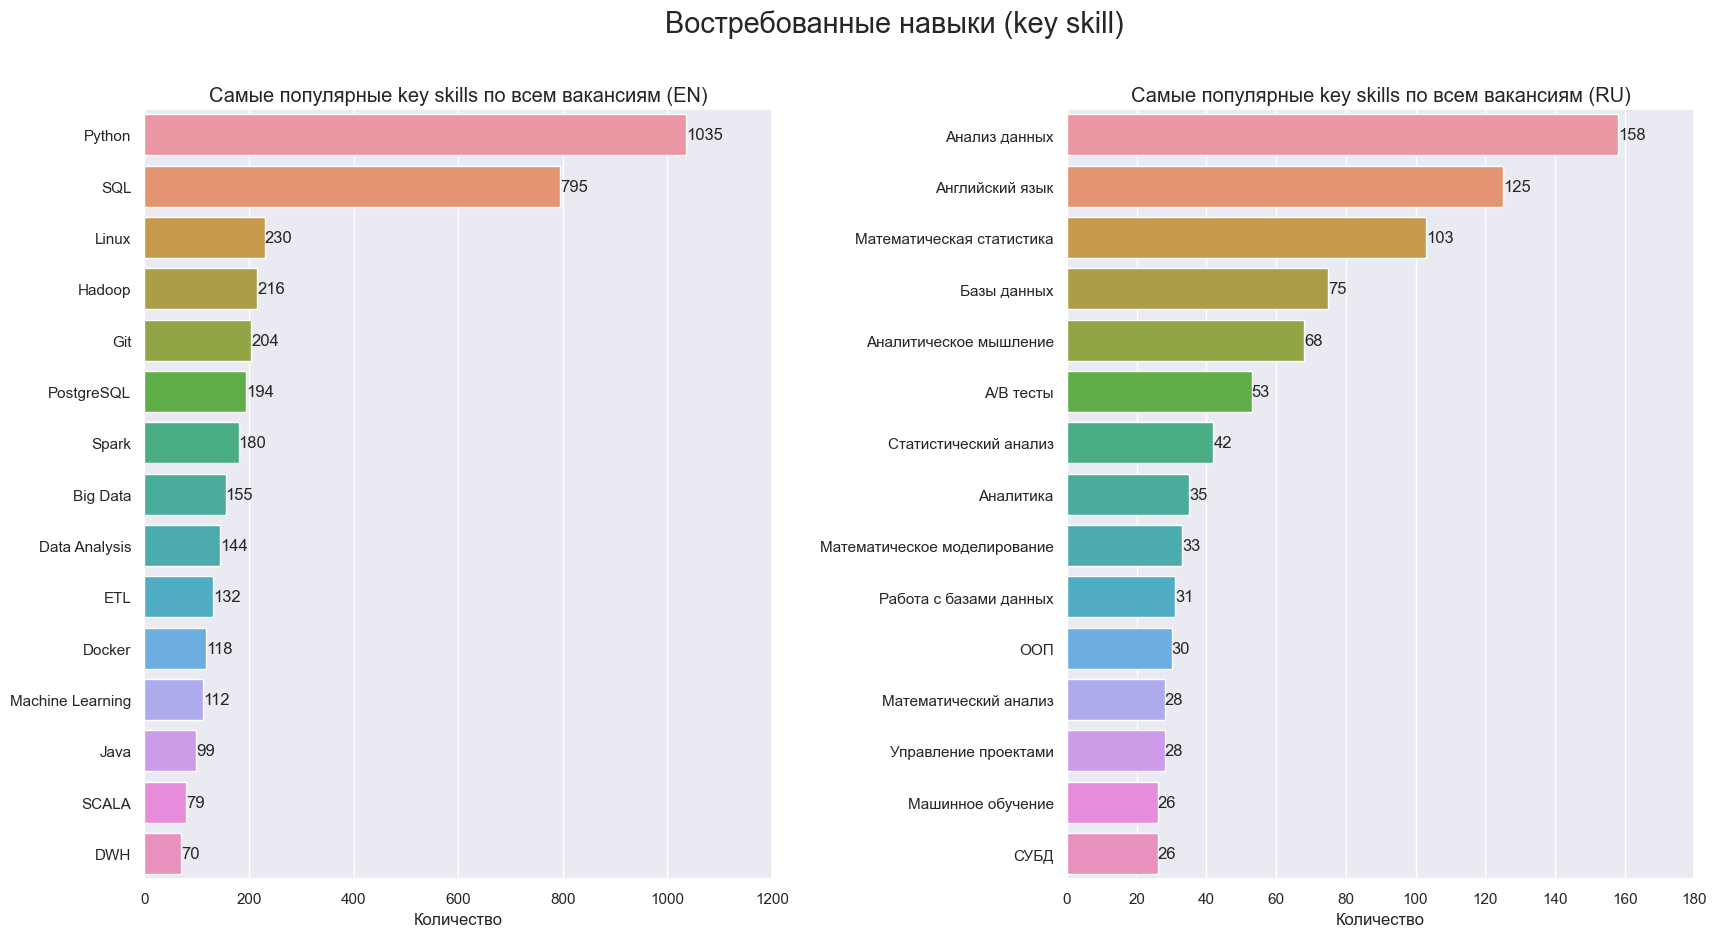

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Востребованные навыки (key skill)', fontsize='xx-large')
plt.subplots_adjust(wspace=0.47)

top_ks_w = check_skills()
sns.barplot(y=top_ks_w.index, x=top_ks_w, ax=ax[0])
ax[0].set_title('Самые популярные key skills по всем вакансиям (EN)', fontsize='large')
ax[0].set_xlabel('Количество')
ax[0].set_xlim(0, 1200)
ax[0].bar_label(ax[0].containers[0])


top_ks_w = check_skills(language='ru')
sns.barplot(y=top_ks_w.index, x=top_ks_w, ax=ax[1])
ax[1].set_title('Самые популярные key skills по всем вакансиям (RU)', fontsize='large')
ax[1].set_xlabel('Количество')
ax[1].set_xlim(0, 180)
ax[1].bar_label(ax[1].containers[0])

plt.savefig('./img/ks_ru_en_count.jpg')
plt.show()

Самыми востребованными навыками для специалиста по данным будут `python` и `SQL`, так как это основной стек вакансий и **английский язык** с **мат. статистикой** (если не учитывать, что навык **анализ данных** это скорее общий навык для в профессии в целом).

Чтобы понять основной стек определённого типа ваканский, стоит рассмотреть поближе для каждого типа:

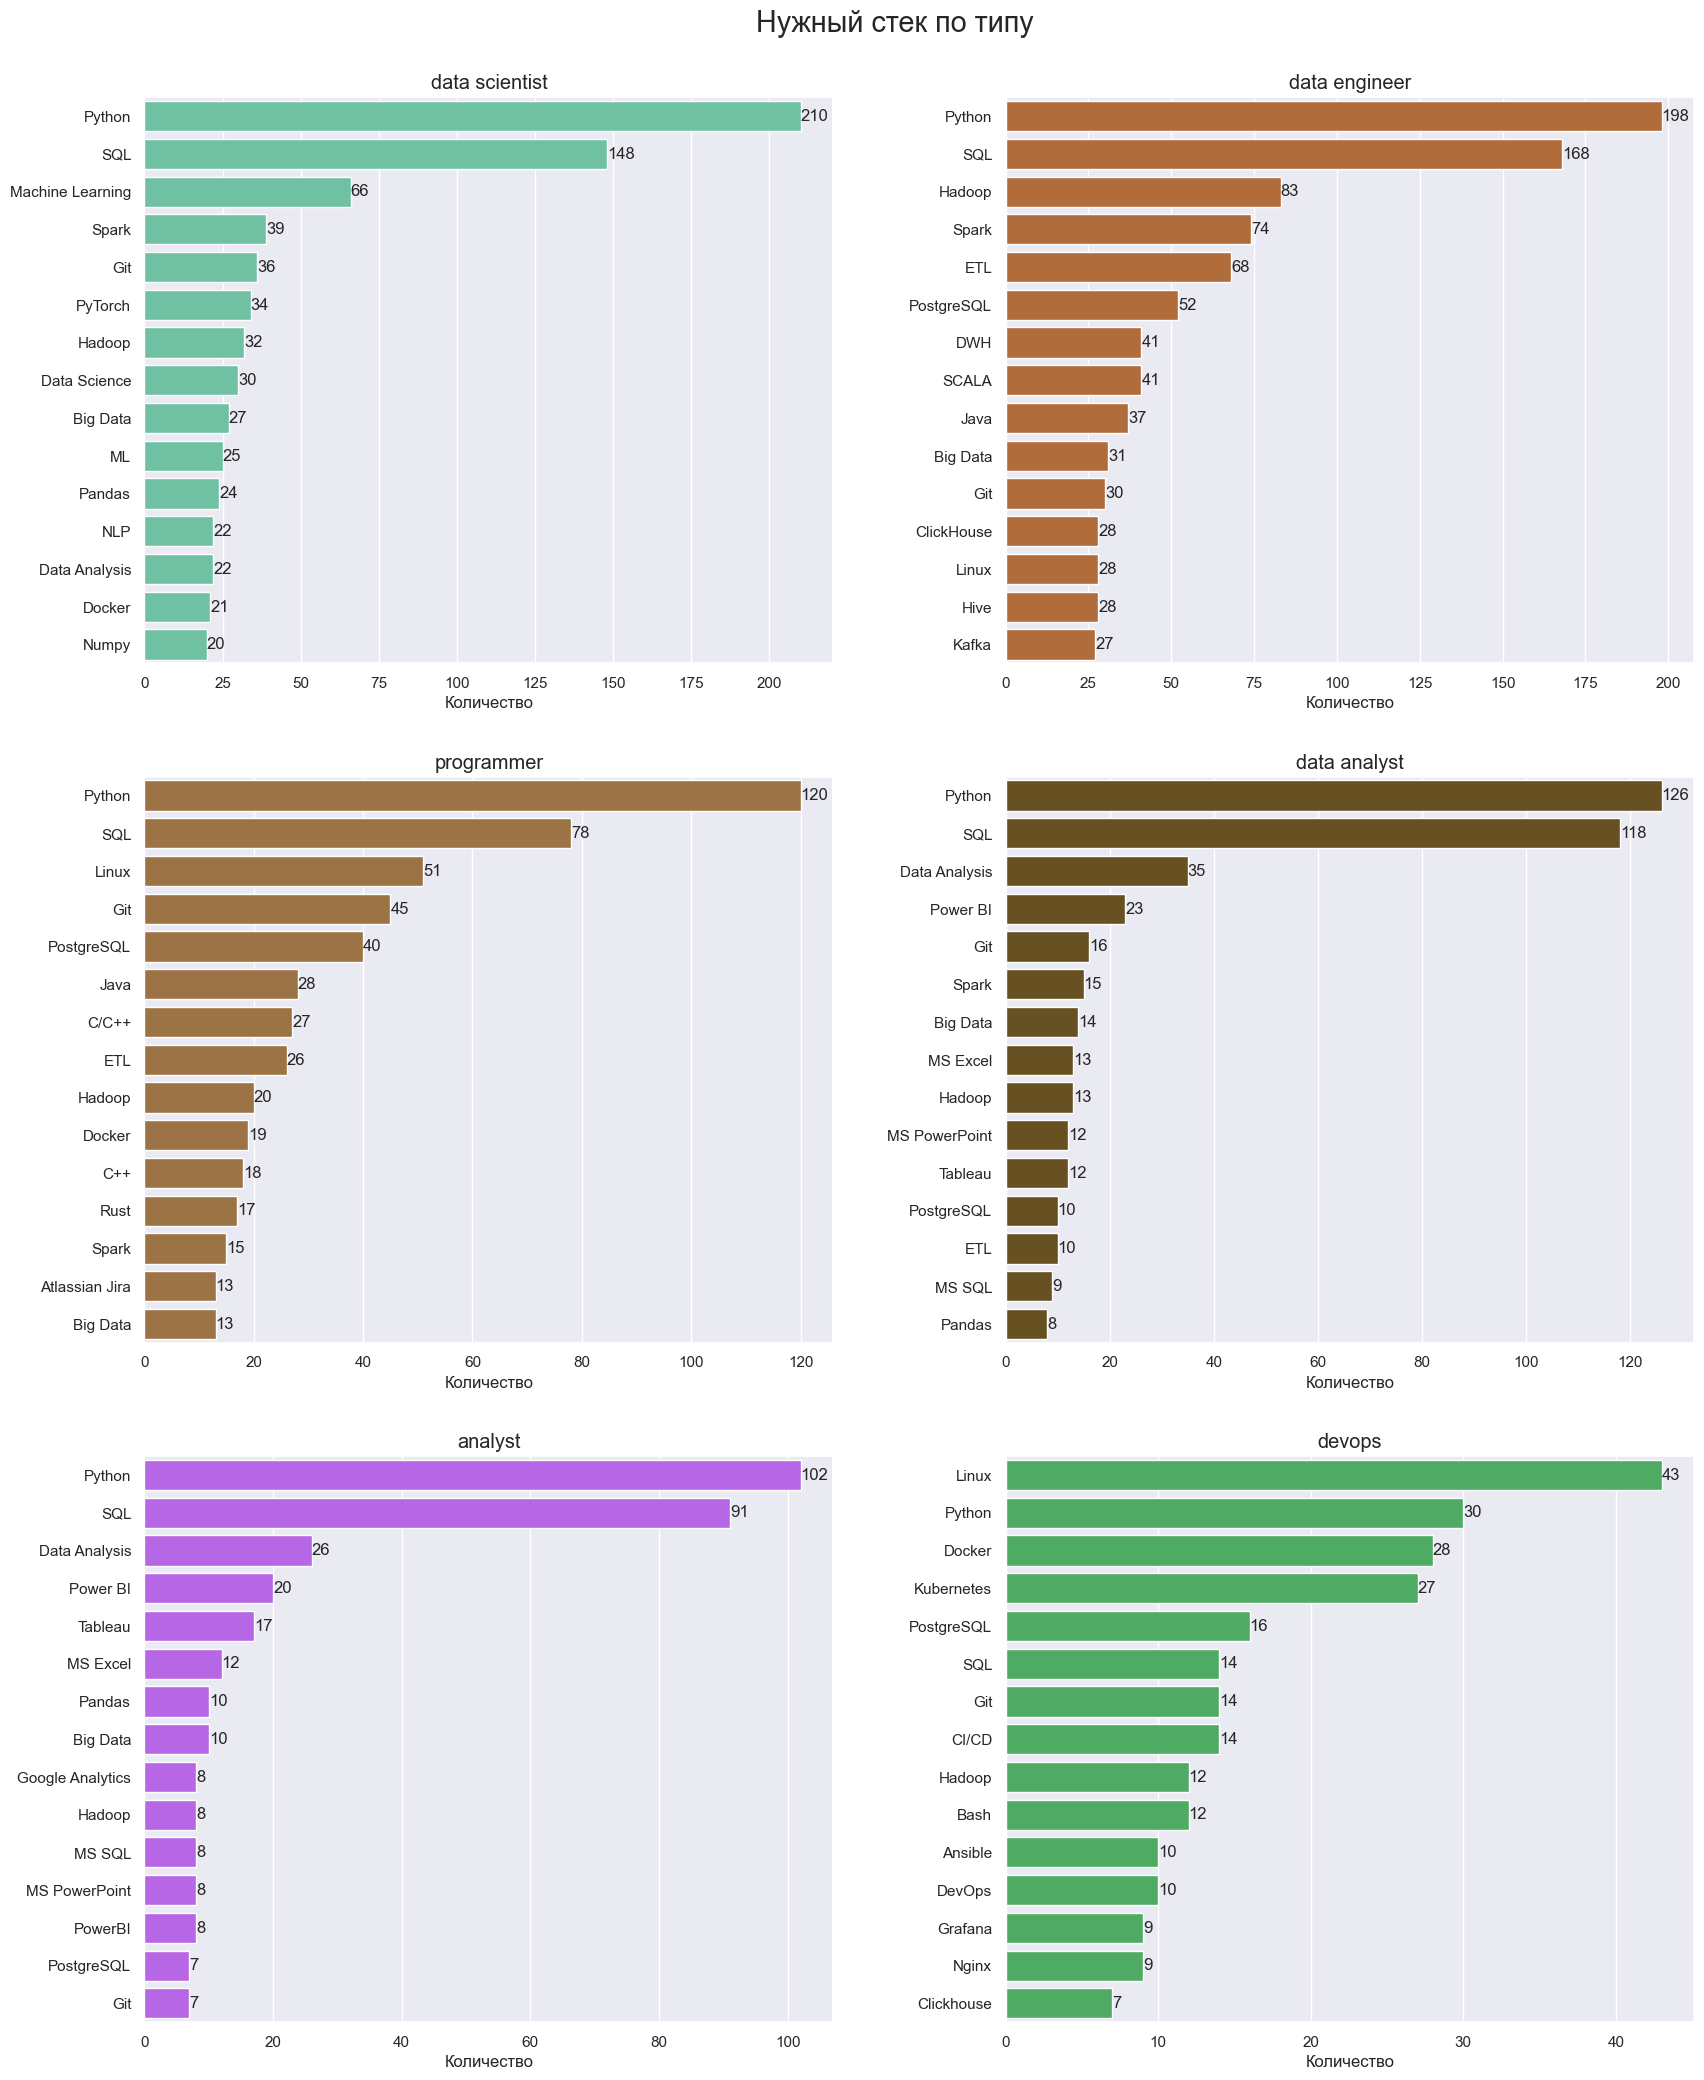

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(20, 25))
fig.suptitle('Нужный стек по типу', fontsize='xx-large', y=0.915)
plt.subplots_adjust(wspace=0.25)

i = 0
for x in range(3):
    for y in range(2):
        top_type = check_skills(counts_top.index[i])
        sns.barplot(y=top_type.index, x=top_type, orient='h', ax=ax[x, y], color=colors[i])
        ax[x, y].bar_label(ax[x, y].containers[0])
        ax[x, y].set_title(f'{counts_top.index[i]}', fontsize='large')
        ax[x, y].set_xlabel('Количество')
        i+=1

plt.savefig('./img/ks_types.jpg')
plt.show()

Рассмотрим навыки без учета основных. И так же будем выбирать именно стек, а не общее название (например *Data Analysis*)

Для самых востребованный вакансий можно выделить основной стек, который наиболее востребован и чаще встречается:

- Git
- Spark
- Hadoop
- Linux

И далее отдельно для своей специфики уже появляются отличия.

Для **Data Scintist'а** - `Machine learning`.

Для **Data engineer'а** - `ETL`, `DWH` и язык `SCALA`.

Для **Programmer** - `ETL`, и языки `Java`, `C++`.

Для **Data analyst'а** - `PowerBI` и `MS Excel`.

### Деятельность компаний

Рассмотрим компании с наибольшим количеством вакансий:

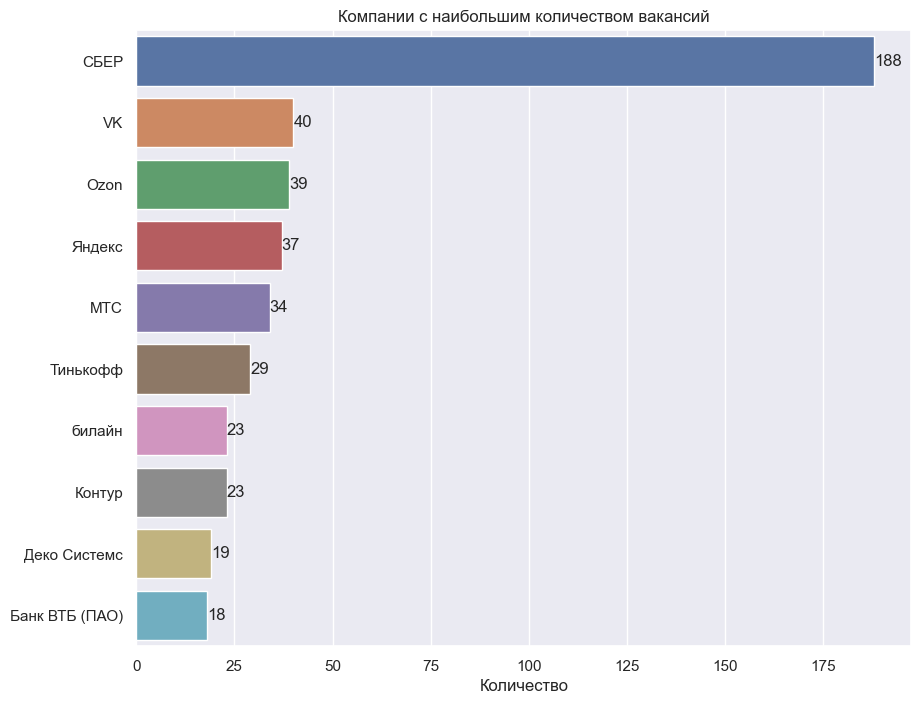

In [28]:
top_comp = df.groupby('company')['id'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 8))
plt.tight_layout()
ax = sns.barplot(y=top_comp.index, x=top_comp, orient='h')
ax.bar_label(ax.containers[0])
plt.title('Компании с наибольшим количеством вакансий')
plt.xlabel('Количество')
plt.ylabel('', visible=False)
plt.savefig('./img/comp_count.jpg', bbox_inches='tight')
plt.show()

Конечно, самое больше всего вакансий у **СБЕР**, так как одна из самых крупных компаний на рынке. 

И дальше идут самые крупные Российские компании на убывание.

Рассмотрим основную проф. деятельность компаний:

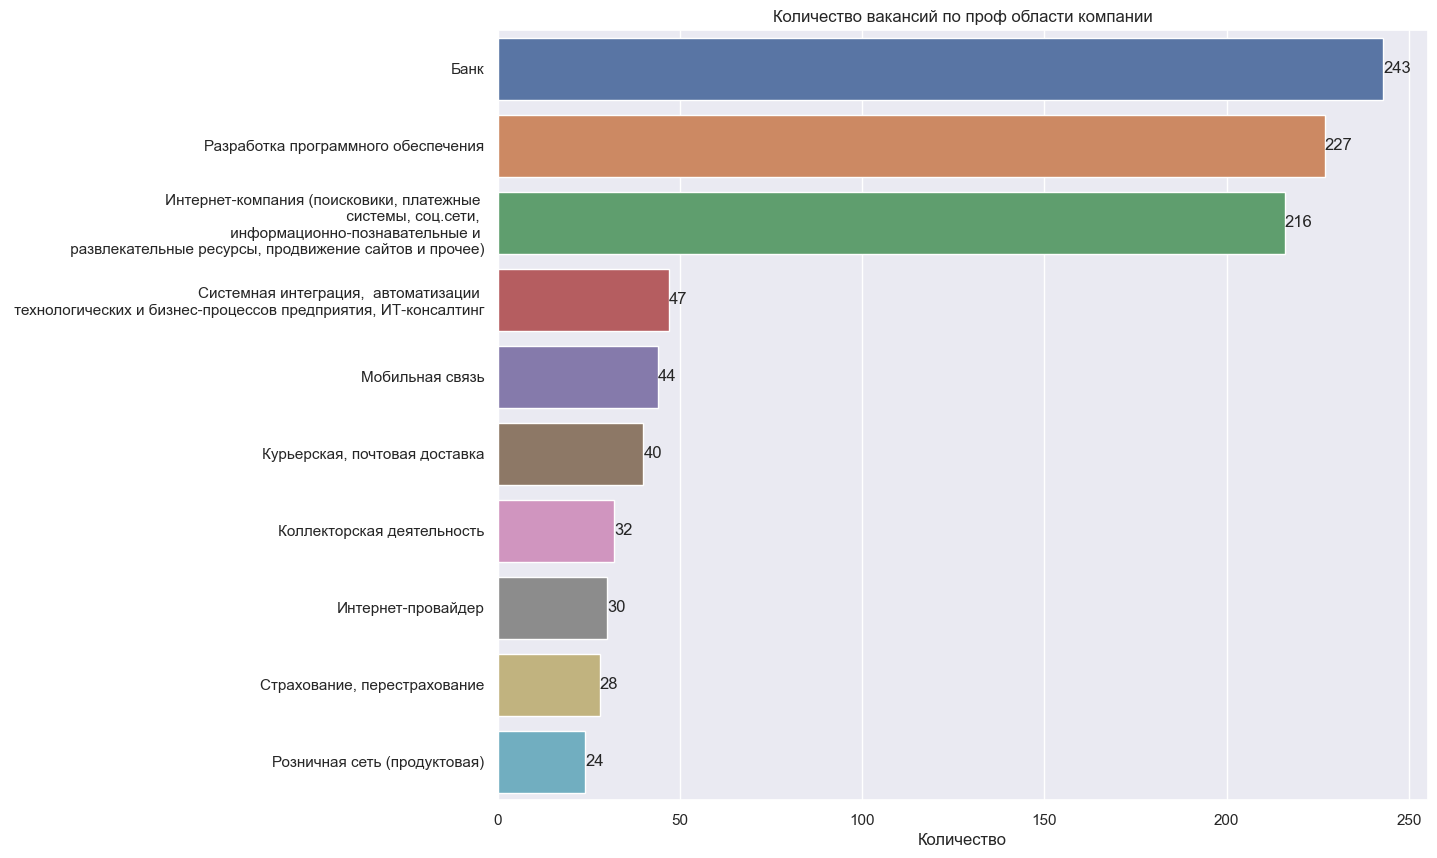

In [29]:
top_ind = df.groupby('industries')['id'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 10))
plt.tight_layout()
ax = sns.barplot(y=top_ind.index, x=top_ind, orient='h')
ax.bar_label(ax.containers[0])
plt.title('Количество вакансий по проф области компании')
plt.xlabel('Количество')
plt.ylabel('', visible=False)
plt.savefig('./img/ind_count.jpg', bbox_inches='tight')
plt.show()

Наиболее востребованы специалисты в компаниях следующих проф. областей:

- Банки
- Разработка программного обеспечения
- Интернет-компании

### Зарплаты

Создадим сводную таблицу и рассмотрим ЗП у компаний, в которых они указаны.

Для сравнения будем рассматривать медиану столбцов *от* и *до*.

In [30]:
df_sal = df[~df['salary'].isna()]

df_sal['salary_median'] = (df_sal['from'] + df_sal['to']) / 2

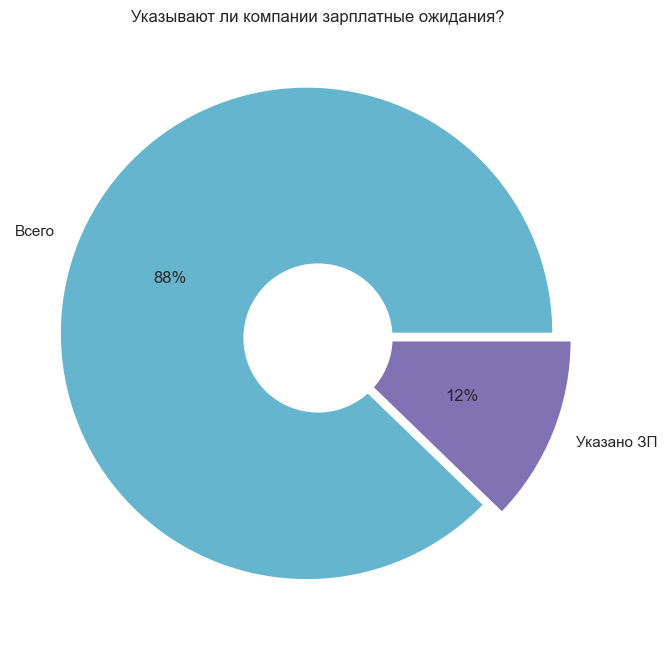

Всего 12% компаний указывают зарплатные ожидания

In [31]:
c_sal = pd.Series({
    'Всего': df.shape[0] - df_sal.shape[0],
    'Указано ЗП': df_sal.shape[0]
})
plt.figure(figsize=(8, 8))
donut = plt.Circle((0,0), 0.3, color = 'white')
plt.pie(c_sal, labels=c_sal.index, explode=[0.05, 0.03], autopct = '%.0f%%', colors=['c', 'm'])
p = plt.gcf()
plt.title('Указывают ли компании зарплатные ожидания?')
p.gca().add_artist(donut)
plt.savefig('./img/c_sal.jpg', bbox_inches='tight')
plt.show()

Markdown(f"Всего {(df_sal.shape[0] / df.shape[0]):.0%} компаний указывают зарплатные ожидания")

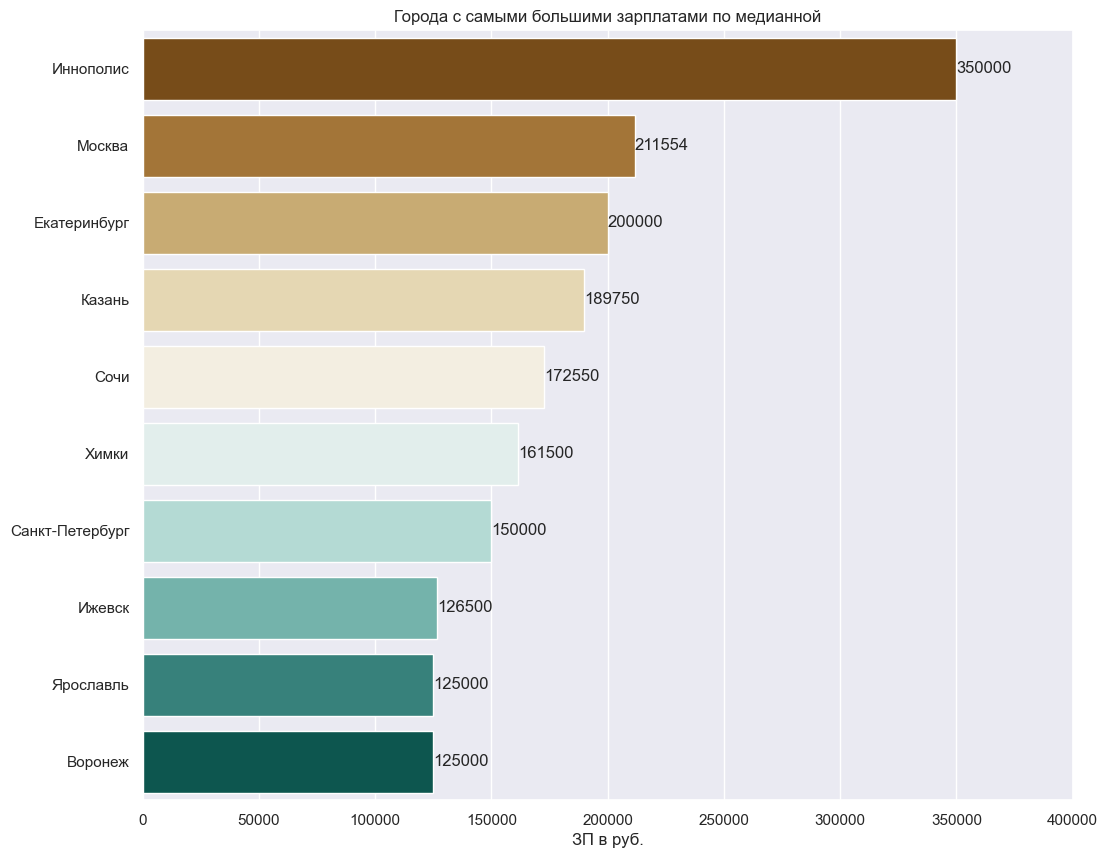

In [32]:
top_sal_city = df_sal.groupby('city')['salary_median'].median().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 10))
ax = sns.barplot(y=top_sal_city.index, x=top_sal_city, orient='h', palette='BrBG')

ax.bar_label(ax.containers[0])
plt.title('Города с самыми большими зарплатами по медианной')
plt.xlabel('ЗП в руб.')
plt.ylabel('', visible=False)
ax.set_xlim(0, 400000)
plt.savefig('./img/top_sal_city.jpg')
plt.show()

Если рассматривать уровни зарплат по медианному значению между *от* и *до*, то самый высокооплачиваемый город на данный момент выгрузки **Иннополис**. Далее идут столица и крупные города.

> Вероятнее всего это из-за того, что выборка совсем небольшая, исследование может каждый раз меняться. Тем более большинство компаний предпочитают не указывать желаемую компенсацию труда.

Рассмотри по медианам от и до раздельно:

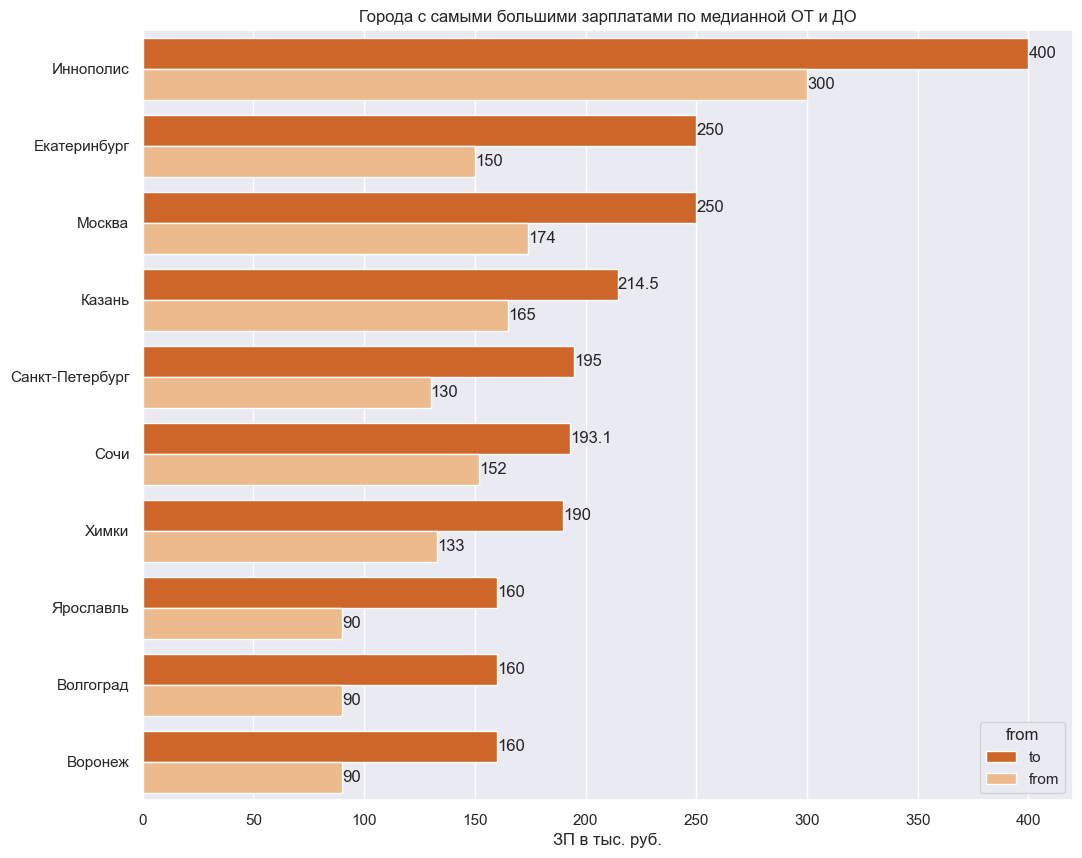

In [33]:
top_sal_city = df_sal.groupby('city')[['from', 'to']].median().sort_values(by='to', ascending=False).head(10)
top_sal_city = top_sal_city.reset_index().melt(id_vars="city", var_name="from", value_name="to")
top_sal_city = top_sal_city.sort_values(['from', 'to'], ascending=False)
top_sal_city.to = top_sal_city.to / 1000

plt.figure(figsize=(12, 10))
ax = sns.barplot(data=top_sal_city, 
                 orient='h', 
                 x=top_sal_city.to, 
                 y=top_sal_city.city, 
                 hue='from', 
                 palette='Oranges_r')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Города с самыми большими зарплатами по медианной ОТ и ДО')
plt.xlabel('ЗП в тыс. руб.')
plt.ylabel('', visible=False)
plt.savefig('./img/top_sal_city_f_t.jpg')
plt.show()

Как видно из графиков, города с самой высокой зарплатой:

- Иннополис
- Москва
- Екатеринбург
- Казань
- Санкт-Петербург

Рассмотрим заработные платы компаний:

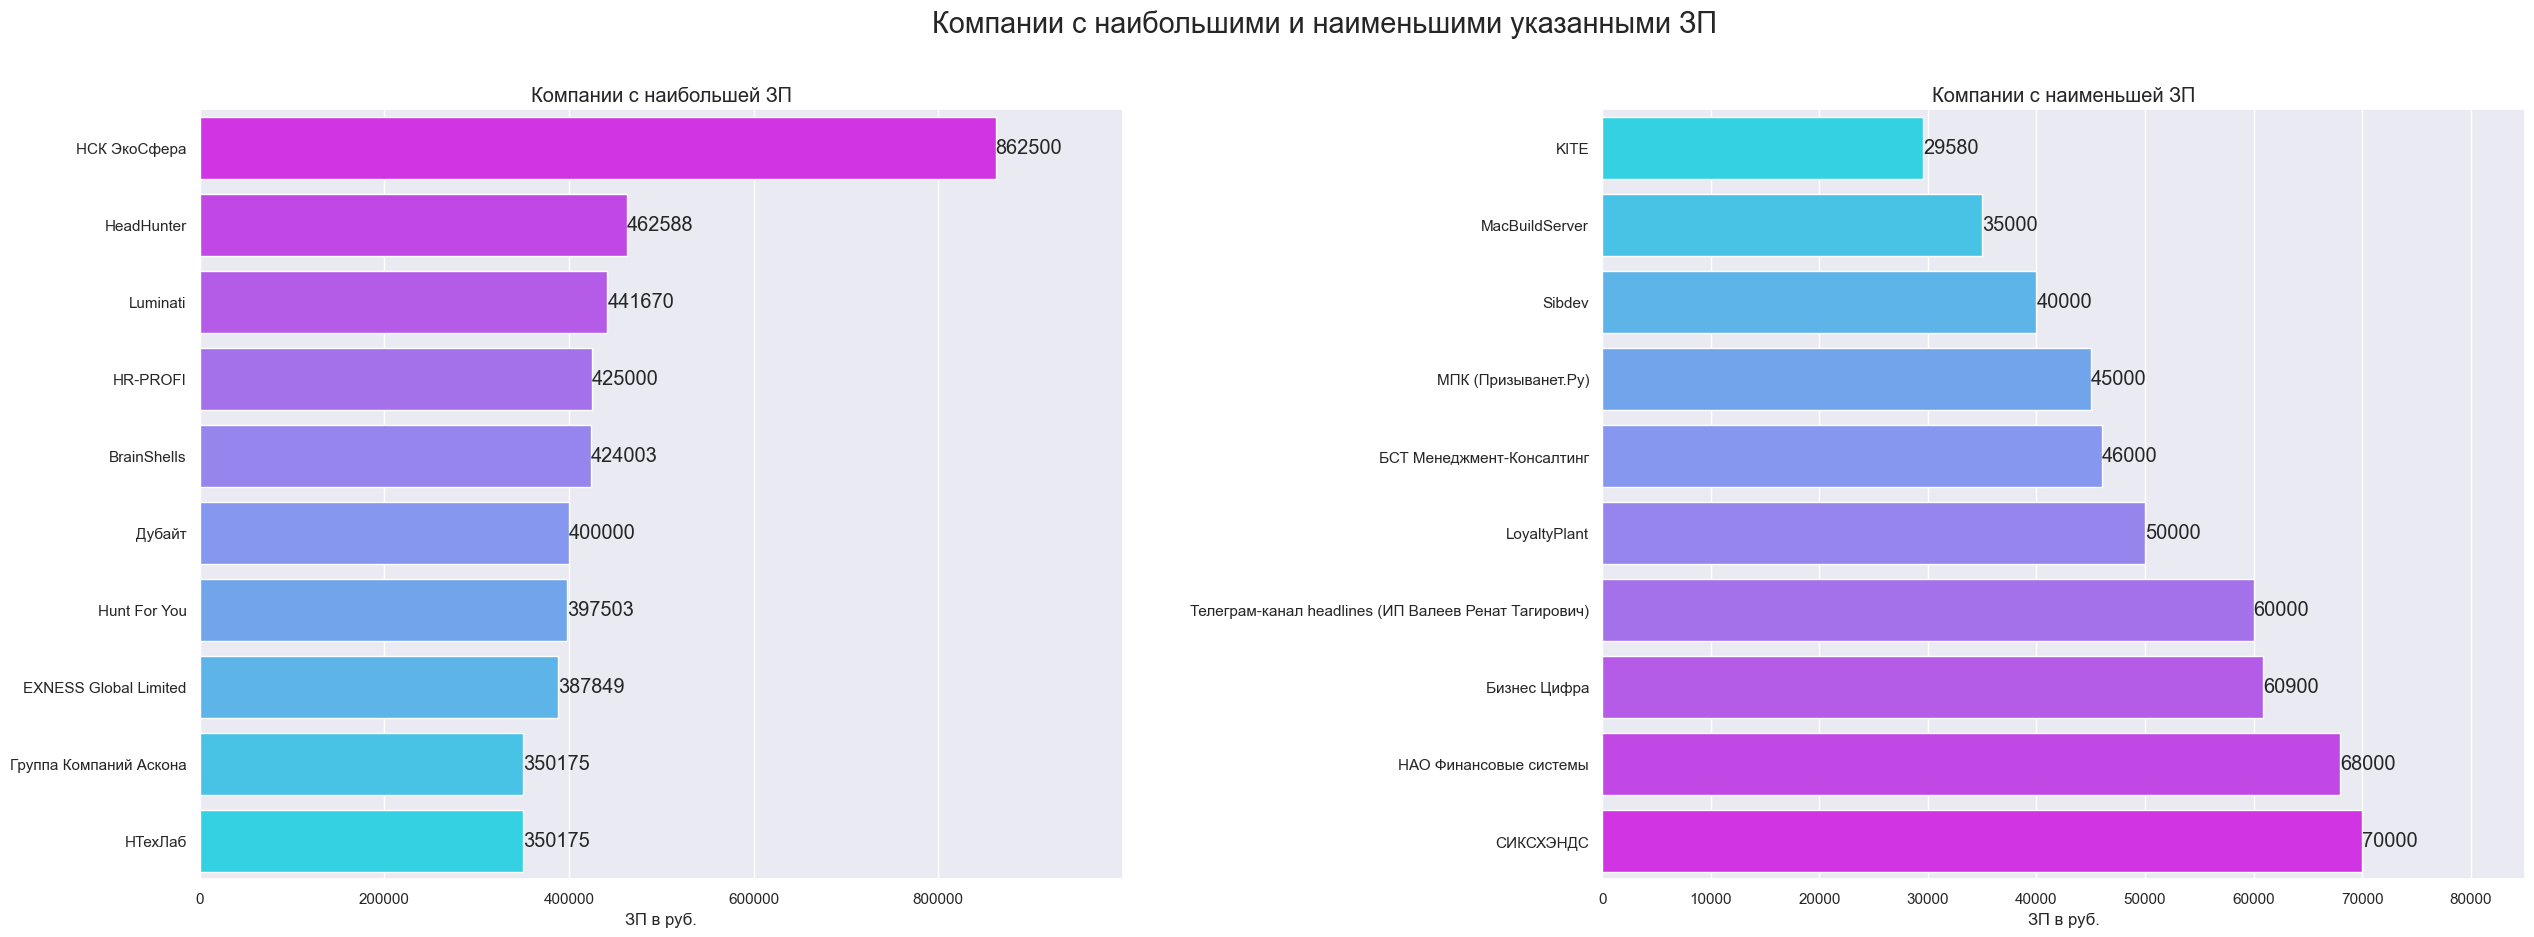

In [34]:
top_max_comp = df_sal.groupby('company')['salary_median'].median().sort_values(ascending=False).head(10)
top_min_comp = df_sal.groupby('company')['salary_median'].median().sort_values(ascending=True).head(10)

fig = plt.figure(figsize=(30, 10))
fig.tight_layout()
fig.suptitle('Компании с наибольшими и наименьшими указанными ЗП', fontsize='xx-large')

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

sns.barplot(y=top_max_comp.index, x=top_max_comp, orient='h', palette='cool_r', ax=ax1)
ax1.set_title('Компании с наибольшей ЗП', fontsize='large')
ax1.set_ylabel('', visible=False)
ax1.set_xlabel('ЗП в руб.')
ax1.bar_label(ax1.containers[0], fontsize='large')
ax1.set_xlim(0, 999999)

sns.barplot(y=top_min_comp.index, x=top_min_comp, orient='h', palette='cool', ax=ax2)
ax2.set_title('Компании с наименьшей ЗП', fontsize='large')
ax2.set_ylabel('', visible=False)
ax2.set_xlabel('ЗП в руб.')
ax2.bar_label(ax2.containers[0], fontsize='large')
ax2.set_xlim(0, 85000)

plt.subplots_adjust(wspace=0.52)
plt.savefig('./img/comp_sal.jpg', bbox_inches='tight')
plt.show()

На графиках изображены компании с наименьшими и наибольшими ЗП.

В связи с тем, что данные постоянно обновляются - какие-то вакансии закрываются, какие-то остаются - точно нельзя выделить компании с наименьшими и наибольшими зарплатами.

Рассмотрим заработные платы по типу вакансии и опыту работы:

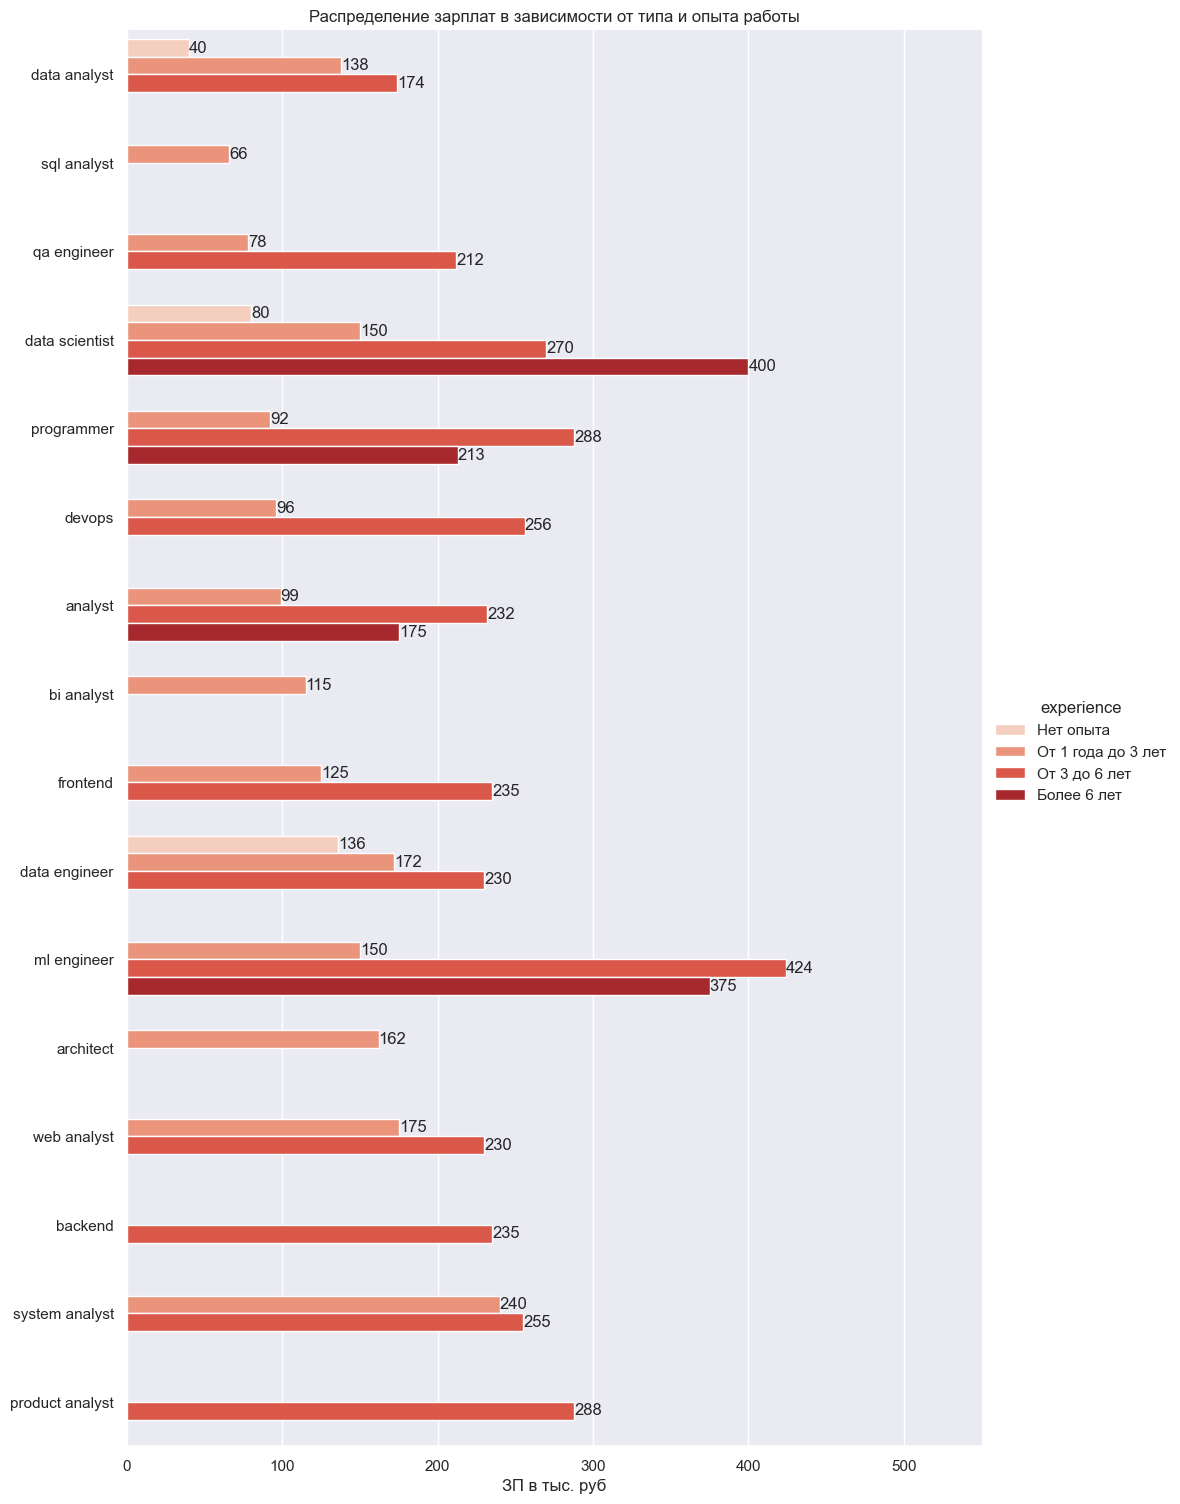

In [35]:
df_grouped = df_sal.groupby(['type_1', 'experience'])['salary_median'].median().round(-3) / 1000
df_grouped = df_grouped.reset_index().sort_values(by=['salary_median'])

g=sns.catplot(
    data=df_grouped,
    kind='bar',
    orient='h',
    x='salary_median',
    y='type_1',
    hue='experience',
    palette='Reds', height=15, aspect=0.7
)
ax = g.facet_axis(0, 0)
plt.title('Распределение зарплат в зависимости от типа и опыта работы')

ax.set_xlim(0, 550)

# iterate through the axes containers
for c in ax.containers:
    ax.bar_label(c, label_type='edge')
    
plt.xlabel('ЗП в тыс. руб')
plt.ylabel('', visible=False)
plt.savefig('./img/type_exp_sal.jpg', bbox_inches='tight')
plt.show()

Исходя из графика выше, на момент выгрузки, самые высокооплачиваемые вакансии, это:
    
- **Data scientist**
- **ML engeneer**

В целом, компании готовы платить специалистам с опытом работы от 1 года **более 150 тыс. руб** на данный момент.


## Выводы

Самые востребованные вакансии:

1. **data scientist**
2. **data engineer**
3. **data analyst**
4. **programmer**
5. **analyst**
6. **devops**

Города с наибольшим количеством вакансий - **Москва** и **Санкт-Петербург**.

Наиболее востребованные у работодателя специалисты уровня `middle` и выше, с опытом работы от *1 года*.

Для самых востребованный вакансий можно выделить основной стек, который чаще указываетя в вакансиях:

- Git
- Spark
- Hadoop
- Linux

И далее отдельно для своей специфики уже появляются отличия:

- Для **Data Scintist'а** - `Machine learning`.
- Для **Data engineer'а** - `ETL`, `DWH` и язык `SCALA`.
- Для **Programmer** - `ETL`, и языки `Java`, `C++`.
- Для **Data analyst'а** - `PowerBI` и `MS Excel`.

Наиболее востребованы специалисты в компаниях следующих проф. областей:

- Банки
- Разработка программного обеспечения
- Интернет-компании

Города с самой высокой зарплатой:

- Иннополис
- Москва
- Екатеринбург
- Казань
- Санкт-Петербург

Самые высокооплачиваемые вакансии:
    
- **Data scientist**
- **ML engeneer**

В целом, компании готовы платить специалистам с опытом работы от 1 года **более 150 тыс. руб** на данный момент.

---

Самые востребованные вакансии у соискателей:

- **data analyst**
- **data scientist**

Чаще откликаются на грейды `junior` и ниже, с требуемым опытом работы *от 1 года*. 

## Дополнительные графики в отчет

In [36]:
import geopandas
from geopandas.tools import geocode

 
def location(city):
    location = geocode(city, provider="nominatim" , user_agent = 'my_request')
    return pd.Series([location['geometry'].x[0], location['geometry'].y[0]])

cities = df.groupby('city').count()['id']
cities = pd.DataFrame({'city':cities.index, 'vacancies':cities.values})
cities[['x', 'y']] = cities['city'].apply(location)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

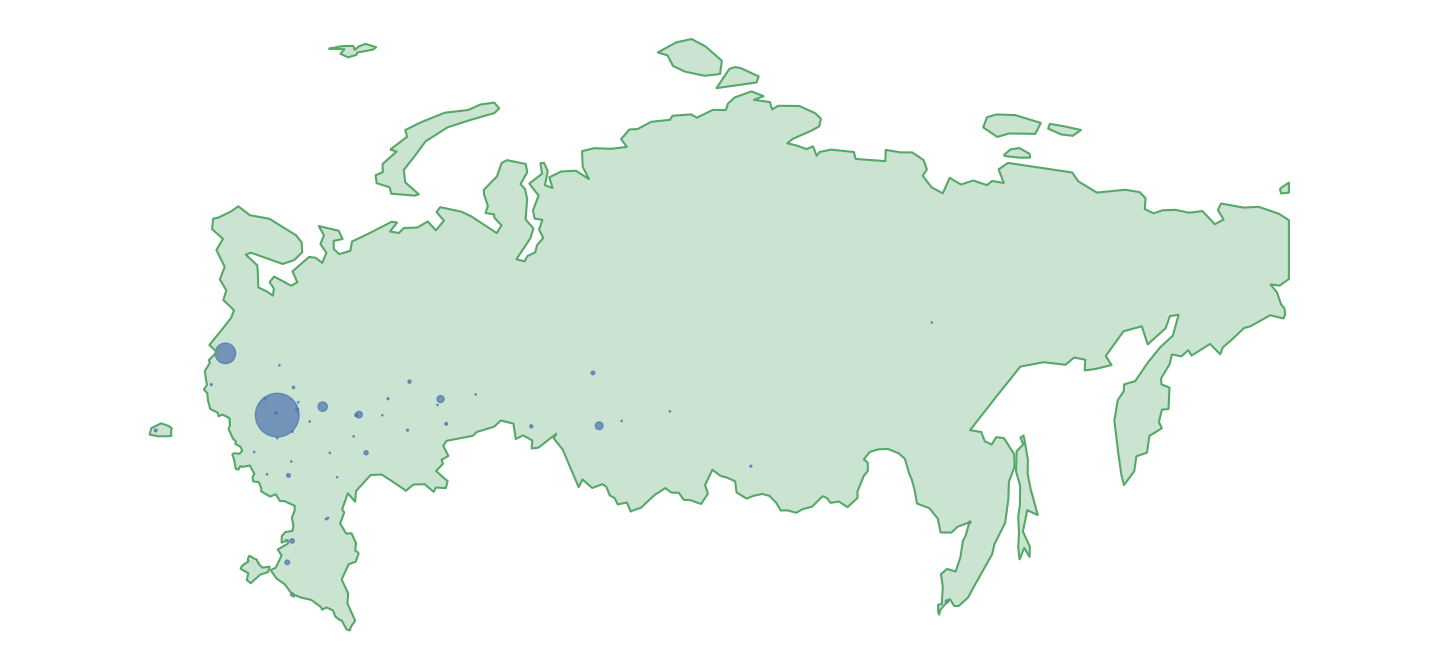

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world[world.name=='Russia'].plot(color='g', ax=ax, alpha=0.3)
world[world.name=='Russia'].boundary.plot(color='g', ax=ax)
ax.scatter(x=cities.x, y=cities.y, s=cities.vacancies, alpha=0.7)
plt.xlim(0, 200)
plt.tight_layout()
ax.set_axis_off()
plt.savefig('./img/rus_vac.jpg', bbox_inches='tight')
plt.show()